In [1]:
import pandas as pd
import copy
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import copy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from skyfield import almanac
from datetime import datetime
from skyfield import api
from sklearn.preprocessing import MinMaxScaler
# import plotly.express as px
import statistics
import random
sc=MinMaxScaler(feature_range=(0,1))
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress
import matplotlib.dates as dates
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
from tensorflow.keras import backend as K
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
# Import all Excel Sheets
CMIPValues_CMCC_CM2_SR5_585=pd.read_excel('Path\To\File\CMIPValues_CMCC_CM2_SR5_585_Fulldataset.xlsx')
CMIPValues_CMCC_CM2_SR5_245=pd.read_excel('Path\To\File\CMIPValues_CMCC_CM2_SR5_245_Fulldataset.xlsx')

CMIPValues_CESM2_245=pd.read_excel('Path\To\File\CMIPValues_CESM2_245_Fulldataset.xlsx')
CMIPValues_CESM2_585=pd.read_excel('Path\To\File\CMIPValues_CESM2_585_Fulldataset.xlsx')

CMIPValues_NorESM2_MM_585=pd.read_excel('Path\To\File\CMIPValues_NorESM2_MM_585_Fulldataset.xlsx')
CMIPValues_NorESM2_MM_245=pd.read_excel('Path\To\File\CMIPValues_NorESM2_MM_245_Fulldataset.xlsx')

CMIPValues_CMCC_ESM2_585=pd.read_excel('Path\To\File\CMIPValues_CMCC_ESM2_585_Fulldataset.xlsx')
CMIPValues_CMCC_ESM2_245=pd.read_excel('Path\To\File\CMIPValues_CMCC_ESM2_245_Fulldataset.xlsx')

ObservedDataset = pd.read_excel(r'Path\To\File\Cumulative_Dataset_Polygon_Mosq_Update2.xlsx')
ObservedDataset=ObservedDataset.drop(columns=['Unnamed: 0'])

Daylight = pd.read_excel(r'Path\To\File\DaylightDataset.xlsx')
Daylight=Daylight.drop(columns=['Sunrise','Sunset','Daylight','Unnamed: 0','Moving Daylight'])
# Change to Kelvin
ObservedDataset['Mean Temp']=ObservedDataset['Mean Temp (°C)']+273.15
ObservedDataset=ObservedDataset.drop(columns=['Mean Temp (°C)'])
ObservedDataset['Moving Mean Temp']=ObservedDataset['Moving Mean Temp']+273.15

CMIPValues_CMCC_CM2_SR5_245['Surface Temp']=CMIPValues_CMCC_CM2_SR5_245['Surface Temp']+273.15
CMIPValues_CMCC_CM2_SR5_245['Moving Surface Temp']=CMIPValues_CMCC_CM2_SR5_245['Moving Surface Temp']+273.15
CMIPValues_CMCC_CM2_SR5_585['Surface Temp']=CMIPValues_CMCC_CM2_SR5_585['Surface Temp']+273.15
CMIPValues_CMCC_CM2_SR5_585['Moving Surface Temp']=CMIPValues_CMCC_CM2_SR5_585['Moving Surface Temp']+273.15
CMIPValues_CESM2_245['Surface Temp']=CMIPValues_CESM2_245['Surface Temp']+273.15
CMIPValues_CESM2_245['Moving Surface Temp']=CMIPValues_CESM2_245['Moving Surface Temp']+273.15
CMIPValues_CESM2_585['Surface Temp']=CMIPValues_CESM2_585['Surface Temp']+273.15
CMIPValues_CESM2_585['Moving Surface Temp']=CMIPValues_CESM2_585['Moving Surface Temp']+273.15

CMIPValues_NorESM2_MM_585['Surface Temp']=CMIPValues_NorESM2_MM_585['Surface Temp']+273.15
CMIPValues_NorESM2_MM_585['Moving Surface Temp']=CMIPValues_NorESM2_MM_585['Moving Surface Temp']+273.15
CMIPValues_NorESM2_MM_245['Surface Temp']=CMIPValues_NorESM2_MM_245['Surface Temp']+273.15
CMIPValues_NorESM2_MM_245['Moving Surface Temp']=CMIPValues_NorESM2_MM_245['Moving Surface Temp']+273.15
CMIPValues_CMCC_ESM2_585['Surface Temp']=CMIPValues_CMCC_ESM2_585['Surface Temp']+273.15
CMIPValues_CMCC_ESM2_585['Moving Surface Temp']=CMIPValues_CMCC_ESM2_585['Moving Surface Temp']+273.15
CMIPValues_CMCC_ESM2_245['Surface Temp']=CMIPValues_CMCC_ESM2_245['Surface Temp']+273.15
CMIPValues_CMCC_ESM2_245['Moving Surface Temp']=CMIPValues_CMCC_ESM2_245['Moving Surface Temp']+273.15

In [4]:
# Import individual variables
SM = pd.read_excel(r'Path\To\File\SoilMoisturePolygon.xlsx')
VD = pd.read_excel(r'Path\To\File\VegetationDataPolygon.xlsx')
ClimateData = pd.read_excel(r'Path\To\File\ClimateDataNew2023.xlsx')
StreamflowData = pd.read_excel(r'Path\To\File\Streamflow2023.xlsx')
ClimateData['Mean Temp']=ClimateData['Mean Temp (°C)']+273.15
ClimateData=ClimateData.drop(columns=['Mean Temp (°C)'])

# Clean the files. This portion will be used to take the bias ratio/bias sum depending on the variable you're working with
SM['Date']=pd.to_datetime(SM['Date'])
SM['Year']=SM['Date'].dt.to_period('Y')
SM['Month']=SM['Date'].dt.to_period('M')
idx = pd.date_range('2002-01-01', '2017-12-31')
SMtest=copy.deepcopy(SM)
SMtest.set_index('Date', inplace=True)
SMtest = SMtest.reindex(idx, fill_value=np.nan)
SMtest = SMtest.reset_index()
SMtest.rename(columns = {'index':'Date'}, inplace = True)
SMtest['Date']=pd.to_datetime(SMtest['Date'])
SMtest['Year']=SMtest['Date'].dt.year
SMtest['Month']=SMtest['Date'].dt.month
SMtest=SMtest.drop(columns=['Unnamed: 0','Count'])
SMtest['SM']=SMtest['SM'].interpolate(method='linear')
SMtest['Moving SM']=SMtest['SM']
SMtest.fillna(method='bfill', inplace=True)

VD=VD.drop(columns=['Unnamed: 0','Count'])
StreamflowData=StreamflowData.drop(columns=['Unnamed: 0'])
ClimateData=ClimateData.drop(columns=['Unnamed: 0','Year','Month','Day','Latitude (y)','Longitude (x)'])

# compile datasets for the anomaly ratio later on
AnomalyCalcObservedPeriod=pd.merge(StreamflowData, VD, how = 'right', left_on = ['Date'], right_on = ['Date'])
AnomalyCalcObservedPeriod=pd.merge(SMtest, AnomalyCalcObservedPeriod, how = 'right', left_on = ['Date'], right_on = ['Date'])
AnomalyCalcObservedPeriod=pd.merge(ClimateData, AnomalyCalcObservedPeriod, how = 'right', left_on = ['Date'], right_on = ['Date'])

AnomalyCalcObservedPeriod['Year']=AnomalyCalcObservedPeriod['Date'].dt.to_period('Y')
AnomalyCalcObservedPeriod['Month']=AnomalyCalcObservedPeriod['Date'].dt.to_period('M')
AnomalyCalcObservedPeriod['Day']=AnomalyCalcObservedPeriod['Date'].dt.to_period('D')

ActualObs=AnomalyCalcObservedPeriod[AnomalyCalcObservedPeriod['Year']<2018]
AnomalyCalcObservedPeriod=AnomalyCalcObservedPeriod[AnomalyCalcObservedPeriod['Year']<2015]
AnomalyCalcObservedPeriod=AnomalyCalcObservedPeriod.dropna()
AnomalyCalcObservedPeriod=AnomalyCalcObservedPeriod[~((AnomalyCalcObservedPeriod['Month']==2) &  (AnomalyCalcObservedPeriod['Day']==29))]

In [5]:
# Getting actual obs data for lookback
ActualObs=pd.merge(Daylight, ActualObs, how = 'inner', left_on = ['Date'], right_on = ['Date'])
ActualObs['Timeskip']=ActualObs['Date']
for i in range(0,len(ActualObs)):
    try:
        ActualObs['Timeskip'][i]=ActualObs['Date'][i+1]-ActualObs['Date'][i]
        ActualObs['Timeskip'][i]=ActualObs['Timeskip'][i].total_seconds()
    except KeyError:
        ActualObs['Timeskip'][i]=0

def calc_rolling_mean(df, col_name, window_size):
    numbers_series = pd.Series(df[col_name])
    windows = numbers_series.rolling(window_size).mean()
    df[f'Moving {col_name}'] = windows
    df[f'Moving {col_name}'][0:6] = df[col_name][0:6]
# Calcing rolling mean and setting the initial values to what is originally in the dataset
window_size = 7
for col_name in ['Total Precip (mm)', 'Mean Temp','SM', 'Outflow (m^3/s)', 'LAI','Daylight_s']:
    calc_rolling_mean(ActualObs, col_name, window_size)
ObservedDataset['Timeskip']=ObservedDataset['Date']
for i in range(0,len(ObservedDataset)):
    try:
        ObservedDataset['Timeskip'][i]=ObservedDataset['Date'][i+1]-ObservedDataset['Date'][i]
        ObservedDataset['Timeskip'][i]=ObservedDataset['Timeskip'][i].total_seconds() # important step - wee need timeskip
    except KeyError:
        ObservedDataset['Timeskip'][i]=0

In [6]:
ActualObs.rename(columns={'Moving Daylight_s': 'Moving Daylight'}, inplace=True)
ActualObs.rename(columns={'Moving Total Precip (mm)': 'Moving Total Precip'}, inplace=True)
x_data = []
y_data = []
cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip','Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM','Timeskip']

# Setting up the dataset for LSTM input in training and testing
for _, row in ObservedDataset.iterrows():
    date = row['Date']
    mosquito_count = row['# of Mosquitoes Rolling']
    timeskip_value = row['Timeskip']
    start_date = date - pd.Timedelta(days=60)
    mask = (ActualObs['Date'] > start_date) & (ActualObs['Date'] <= date)
    subset_ActualObs = ActualObs[mask].copy()
    if len(subset_ActualObs) == 60:
        subset_ActualObs['Timeskip'] = timeskip_value
        subset_values = subset_ActualObs[cols].values
        x_data.append(subset_values)
        y_data.append(mosquito_count)

x_data = np.array(x_data)
y_data = np.array(y_data)
num_samples, sequence_length, num_features = x_data.shape

# Using the mean and std of the values per LSTM input. 
feature_means = {}
feature_stds = {}
for feature in cols:
    feature_idx = cols.index(feature)
    feature_values = x_data[:,:,feature_idx]
    feature_mean = feature_values.mean()
    feature_std = feature_values.std()
    feature_std = feature_std if feature_std != 0 else 1
    x_data[:,:,feature_idx] = (feature_values - feature_mean) / feature_std
    feature_means[feature] = feature_mean
    feature_stds[feature] = feature_std
feature_stats_df = pd.DataFrame({'Feature': feature_means.keys(), 'Mean': feature_means.values(), 'Standard Deviation': feature_stds.values()})

y_data_mean = y_data.mean()
y_data_std = y_data.std()
y_data_std = y_data_std if y_data_std != 0 else 1
# y_data = (y_data - y_data_mean) / y_data_std
xtrain = np.array(x_data[:2290]).astype('float32')
ytrain = np.array(y_data[:2290]).astype('float32')
xtest = np.array(x_data[2290:3435]).astype('float32')
ytest = np.array(y_data[2290:3435]).astype('float32')

In [7]:
# ObservedDataset=ObservedDataset[ObservedDataset['# of Mosquitoes']!=0]

In [8]:
def custom_loss(dynamic_multiplier, weight_multiplier):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.cast(y_pred, 'float32')
        mean = K.mean(y_true, axis=1, keepdims=True)
        dynamic_threshold = mean * dynamic_multiplier
        weight = tf.where(K.greater(y_true, dynamic_threshold), K.cast(weight_multiplier, 'float32'), 1.0)
        mse = K.mean(weight * K.square(y_true - y_pred))
        return mse
    return loss

num_epochs = 50
batch_size = 16
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(xtrain.shape[1], xtrain.shape[2])))
regressor.add(Dropout(0.0))  
regressor.add(LSTM(units=32, return_sequences=False))  
regressor.add(Dropout(0.1))
regressor.add(Dense(units=1, activation='relu'))
opt = Adam(learning_rate=0.005)
loss_fn = custom_loss(0, 2)
regressor.compile(loss=loss_fn, optimizer=opt)

regressor.fit(xtrain, ytrain, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
129/129 [==============================] - 8s 28ms/step - loss: 11.3265 - val_loss: 3.8449
Epoch 2/50
129/129 [==============================] - 3s 21ms/step - loss: 7.1815 - val_loss: 2.5640
Epoch 3/50
129/129 [==============================] - 3s 20ms/step - loss: 7.0878 - val_loss: 3.8143
Epoch 4/50
129/129 [==============================] - 3s 21ms/step - loss: 7.1569 - val_loss: 3.7005
Epoch 5/50
129/129 [==============================] - 3s 21ms/step - loss: 6.2130 - val_loss: 1.6386
Epoch 6/50
129/129 [==============================] - 3s 21ms/step - loss: 6.0283 - val_loss: 2.0009
Epoch 7/50
129/129 [==============================] - 3s 21ms/step - loss: 5.1461 - val_loss: 1.2068
Epoch 8/50
129/129 [==============================] - 3s 21ms/step - loss: 4.7839 - val_loss: 1.2879
Epoch 9/50
129/129 [==============================] - 3s 21ms/step - loss: 4.3760 - val_loss: 2.0807
Epoch 10/50
129/129 [==============================] - 3s 21ms/step - loss: 4.3622 - val_l

72/72 [==============================] - 0s 6ms/step
0.431236278694362


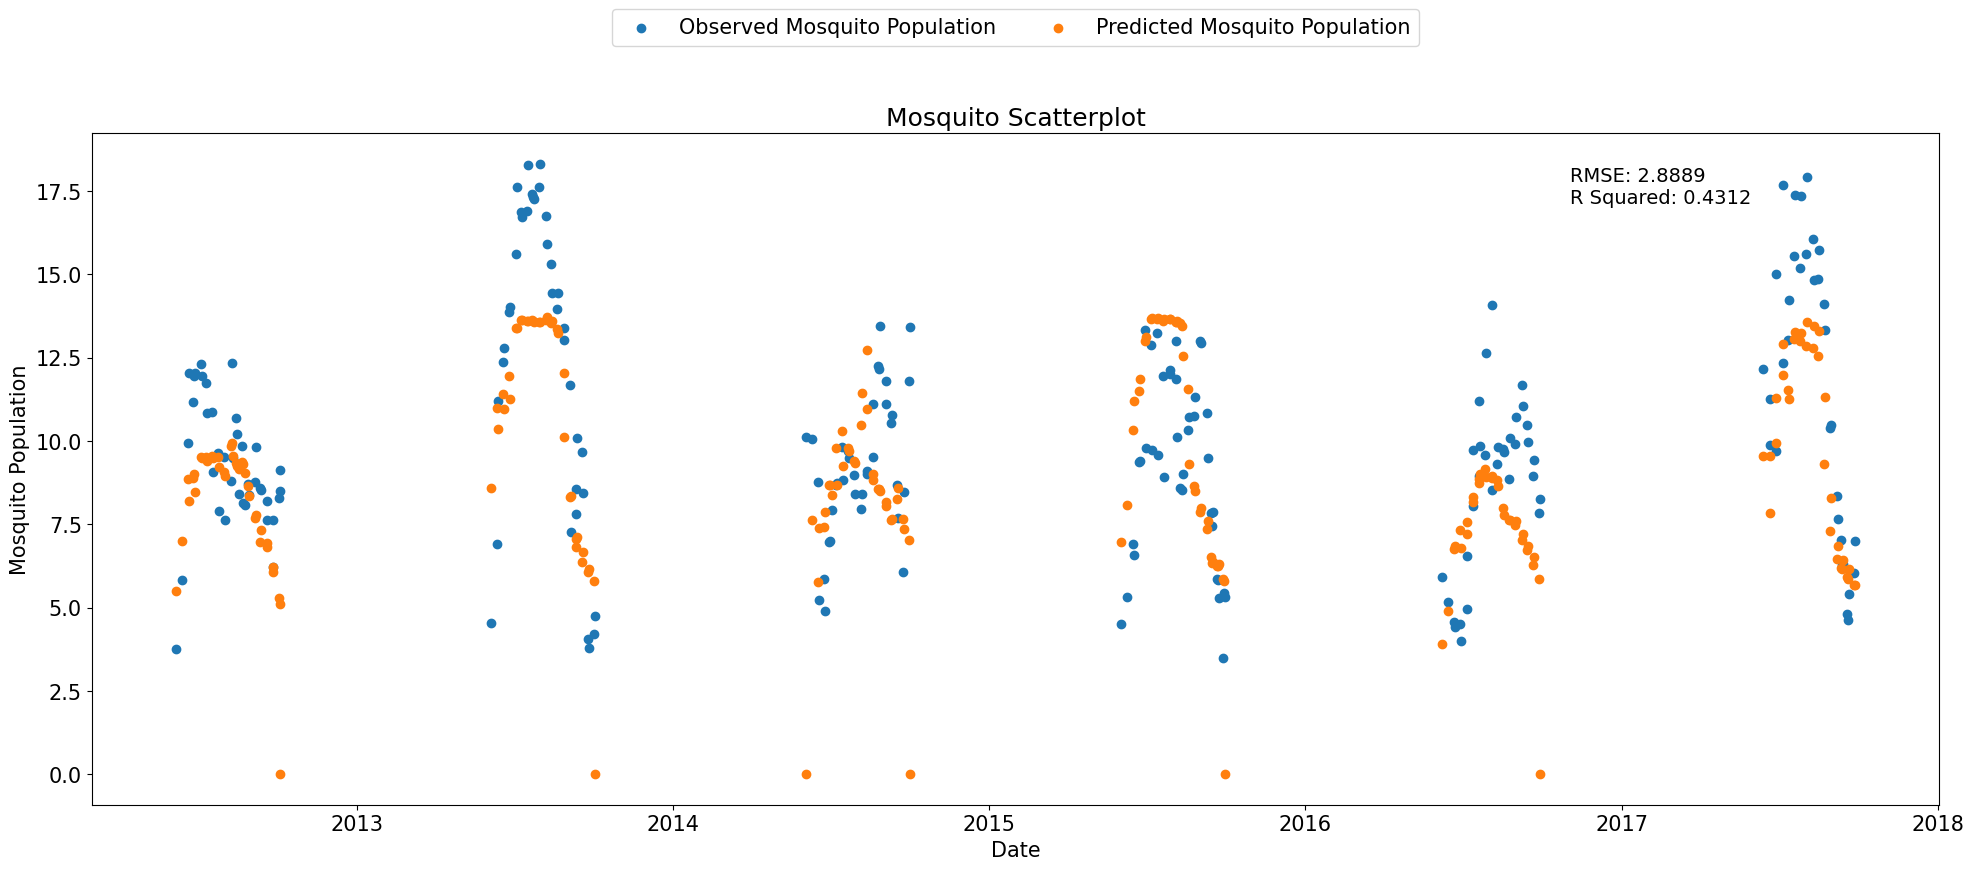

In [9]:
ypred = regressor.predict(xtest)
ypredicttrain=regressor.predict(xtrain)

# Seeing how effective our model is, by comparing actual values to simulated values
TestNo0=pd.DataFrame()
TestNo0['Actual Mosquito Data']=ytest.flatten()
TestNo0['Mosquito Predictions']=ypred.flatten()
TestNo0['Date'] = ObservedDataset.iloc[2290:3435]['Date'].reset_index(drop=True)
TestNo0['Actual Mosquito Data']=TestNo0['Actual Mosquito Data'].round(3)
TestNo0['Mosquito Predictions']=TestNo0['Mosquito Predictions'].round(3)
TestNo0 = TestNo0[TestNo0['Actual Mosquito Data'] != 0]
plt.rcParams["figure.figsize"] = (20,9)
plt.rcParams.update({'font.size': 15})

mse = mean_squared_error(TestNo0['Actual Mosquito Data'], TestNo0['Mosquito Predictions'])
rmse = np.sqrt(mse)
corr_matrix = np.corrcoef(TestNo0['Actual Mosquito Data'], TestNo0['Mosquito Predictions'])
corr = corr_matrix[0,1]
r_sq = corr**2

plt.close('all')
plt.scatter(TestNo0['Date'],TestNo0['Actual Mosquito Data'],label='Observed Mosquito Population')
plt.scatter(TestNo0['Date'],TestNo0['Mosquito Predictions'],label='Predicted Mosquito Population')
text = f"RMSE: {rmse:.4f}\nR Squared: {r_sq:.4f}"
plt.text(0.80, 0.95, text, transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
plt.title('Mosquito Scatterplot')
plt.ylabel('Mosquito Population')
plt.xlabel('Date')

print(r_sq)

plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Overall Variable Correlation Heatmap')

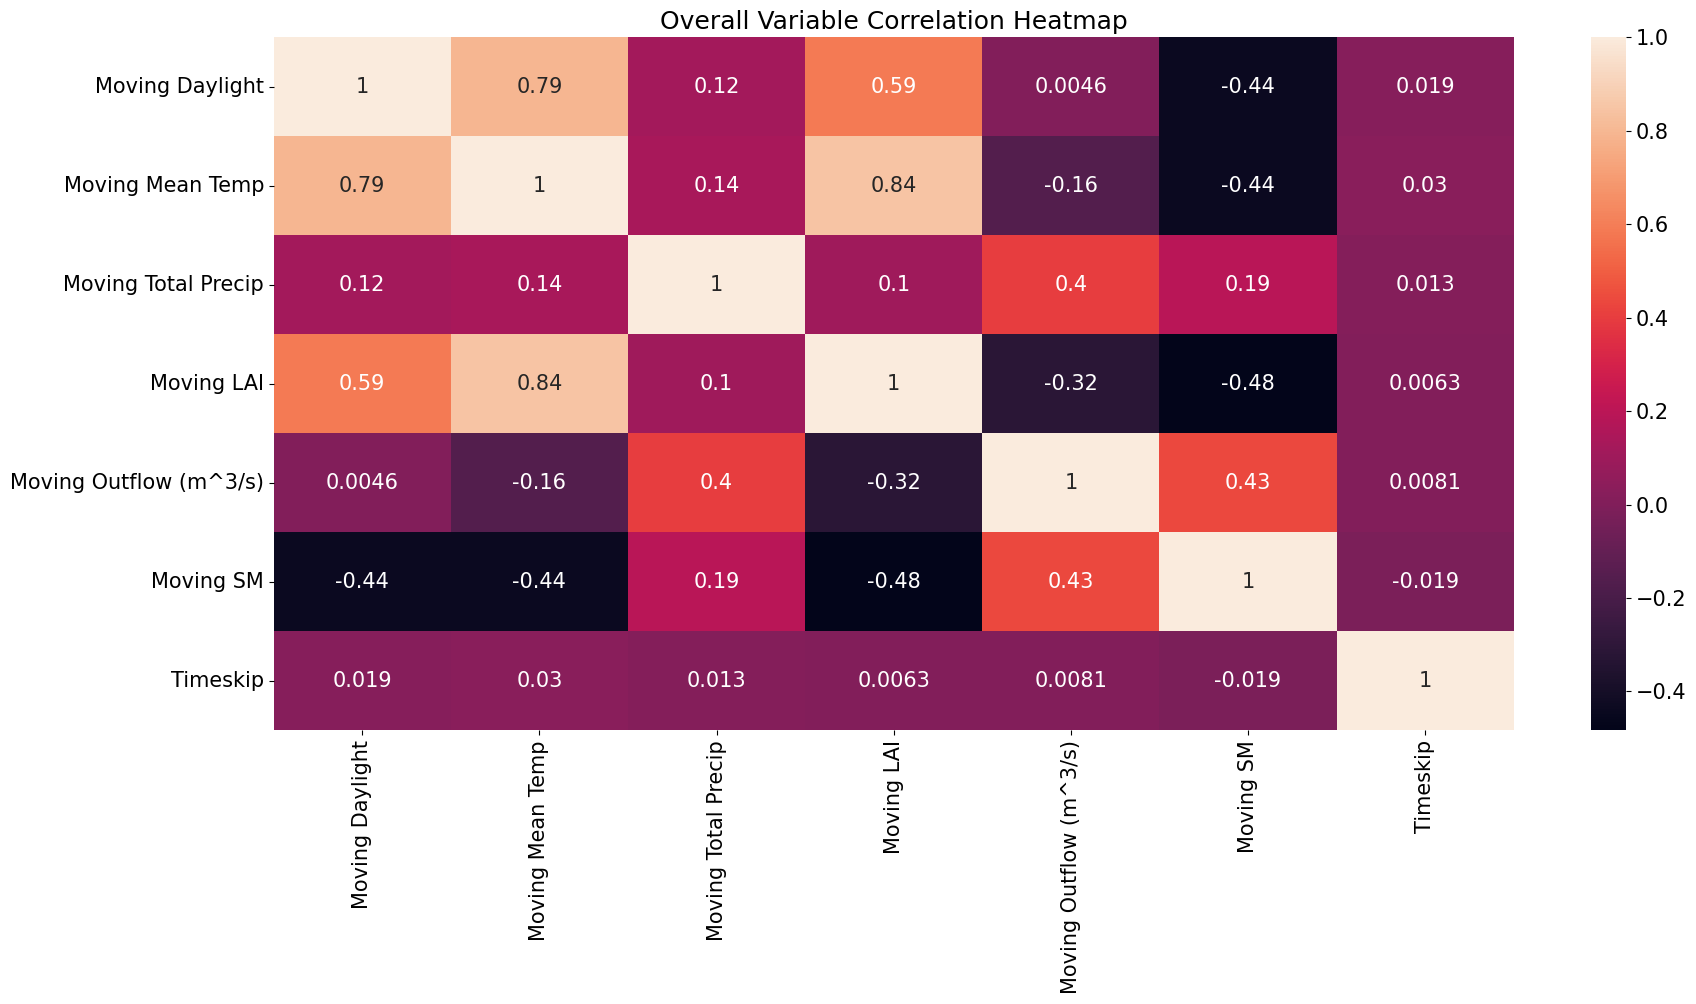

In [10]:
sns.heatmap(ActualObs[cols].corr(),annot=True)
plt.title('Overall Variable Correlation Heatmap')

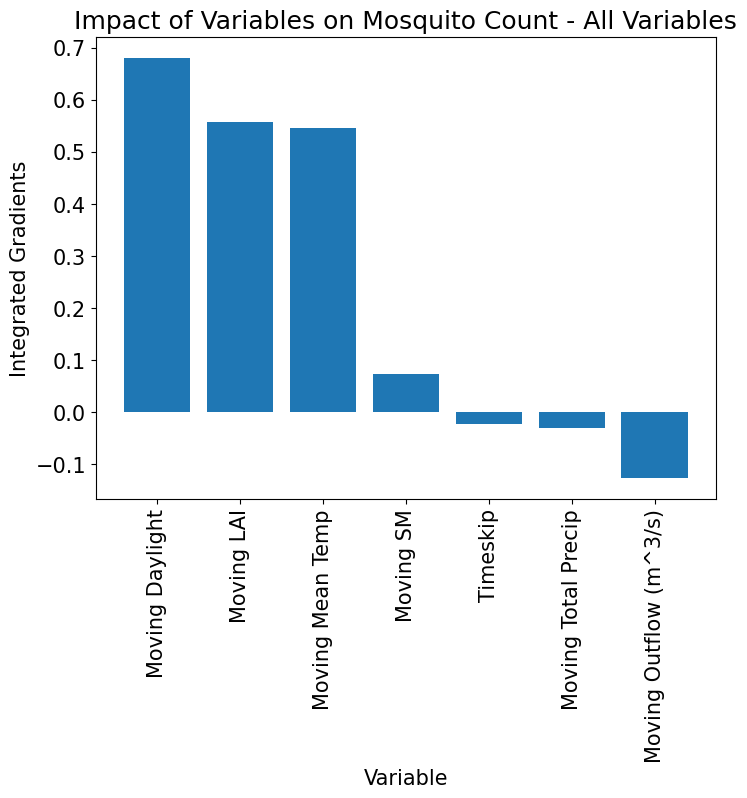

In [11]:
# https://keras.io/examples/vision/integrated_gradients/
# Getting the integrated gradient of each variable to assess the impact on the model - see how effective each one is

def integrated_gradients(model, input_data, baseline, steps):
    all_gradients = []
    # Breaking it up into steps and applying the ig similar tothe keras example
    each_step = [baseline + (step/steps) * (input_data - baseline) for step in range(steps+1)]
    for step_part in each_step:
        step_input_tensor = tf.convert_to_tensor(step_part)
        with tf.GradientTape() as tape:
            tape.watch(step_input_tensor)
            step_predictions = model(step_input_tensor)
        gradients = tape.gradient(step_predictions, step_input_tensor)
        all_gradients.append(gradients)
    avg_gradients = tf.reduce_mean(all_gradients, axis=0)
    integrated_grads = (input_data - baseline) * avg_gradients
    return integrated_grads

# Setting up the baseline and using the training dataset to see what the model is learning
baseline_input = np.zeros_like(xtrain)
integrated_gradients_result = integrated_gradients(regressor, xtrain, baseline_input, steps=25)
integrated_gradients_summed = np.sum(integrated_gradients_result, axis=1)
mean_values = np.mean(integrated_gradients_summed, axis=0)
mean_values = mean_values.flatten()
IGVariableDF = pd.DataFrame({
    'Variable': cols,
    'IG All Variables': mean_values})

sorted_indices = np.argsort(mean_values)[::-1]
sorted_cols = np.array(cols)[sorted_indices]
sorted_mean_values = mean_values[sorted_indices]
plt.figure(figsize=(8, 6))
plt.bar(range(len(sorted_cols)), sorted_mean_values)
plt.xticks(range(len(sorted_cols)), sorted_cols, rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Integrated Gradients')
plt.title('Impact of Variables on Mosquito Count - All Variables')
plt.show()

In [12]:
# Now I'm trying to see how the model would look if we remove certain variables and abs val others. For certain variables, we set the value to 0
# as 0 means there is no impact of that variable. For temperature, it was set to the mean to effectively run the model.
def compute_IG_without_variable(model, x_train, removed_variable_idx, baseline, steps=10, cols=None, mean_temp=None):
    modified_x_train = x_train.copy()
    if cols[removed_variable_idx] == 'Moving Mean Temp' and mean_temp is not None:
        modified_x_train[:, :, removed_variable_idx] = mean_temp # Temp set to mean
    else:
        modified_x_train[:, :, removed_variable_idx] = 0
    integrated_gradients_result = integrated_gradients(
        model, modified_x_train, baseline, steps)
    integrated_gradients_summed = np.sum(integrated_gradients_result, axis=1)
    mean_values = np.mean(integrated_gradients_summed, axis=0)
    abs_mean_values = np.mean(np.abs(integrated_gradients_summed), axis=0) # aforementioned abs vals
    return mean_values, abs_mean_values

cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip', 'Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM', 'Timeskip']
baseline_input = np.zeros_like(xtrain) 
IG_dfs = {}
# computing using xtrain as that is the dataset the model learns from
mean_temp = np.mean(xtrain[:, :, cols.index('Moving Mean Temp')])
for i in range(xtrain.shape[2]):
    mean_values, abs_mean_values = compute_IG_without_variable(regressor, xtrain, i, baseline_input, cols=cols, mean_temp=mean_temp)
    IG_df = pd.DataFrame({
        'Variable': cols,
        'IG values without {}'.format(cols[i]): mean_values,
        'Abs IG values without {}'.format(cols[i]): abs_mean_values})
    IG_dfs[cols[i]] = IG_df

In [13]:
combined_IG_df = IG_dfs[cols[0]]
for var_removed in cols[1:]:
    combined_IG_df = combined_IG_df.merge(IG_dfs[var_removed], on='Variable', how='outer')
combined_IG_df.at[1, 'IG values without Moving Mean Temp'] = 0.00
combined_IG_df.at[1, 'Abs IG values without Moving Mean Temp'] = 0.00

In [14]:
# Creating a color coded map of IG values. Blue means negative, red means positive. The black means the variable was removed.
def color_cells(val):
    if val == float(0):
        return 'background-color: black'
    elif isinstance(val, (int, float)):
        if val < 0:
            return 'background-color: lightblue'
        else:
            return 'background-color: #FFCCCC'
    return '' 
styled_df = combined_IG_df.style.applymap(color_cells)
styled_df

In [15]:
def color_cells(val, col, row):
    if isinstance(val, (int, float)):
        if col == 'Moving Mean Temp' and round(val, 2) == float(0):
            return 'background-color: black'
        elif val == 0:
            return 'background-color: black'
    return ''

styled_df = combined_IG_df.style.apply(lambda x: [color_cells(val, col, x.name) for val, col in zip(x, combined_IG_df.columns)], axis=1)
styled_df

In [16]:
ActualObs.rename(columns={'Moving Daylight_s': 'Moving Daylight'}, inplace=True)
ActualObs.rename(columns={'Moving Total Precip (mm)': 'Moving Total Precip'}, inplace=True)
x_data = []
y_data = []
cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip','Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM','Timeskip']

# Reprepping x data to get variation in mosquitos with changing variables
for _, row in ObservedDataset.iterrows():
    date = row['Date']
    mosquito_count = row['# of Mosquitoes Rolling']
    timeskip_value = row['Timeskip']
    start_date = date - pd.Timedelta(days=60)
    mask = (ActualObs['Date'] > start_date) & (ActualObs['Date'] <= date)
    subset_ActualObs = ActualObs[mask].copy()
    if len(subset_ActualObs) == 60:
        subset_ActualObs['Timeskip'] = timeskip_value
        subset_values = subset_ActualObs[cols].values
        x_data.append(subset_values)
        y_data.append(mosquito_count)

x_data = np.array(x_data)
y_data = np.array(y_data)
num_samples, sequence_length, num_features = x_data.shape

cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip','Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM','Timeskip']
feature_names = []
feature_means = []
feature_stds = []
StartDate=ObservedDataset['Date'][0]-pd.Timedelta(days=60)
LastDate = ObservedDataset['Date'].tail(1).iloc[0]
mask = (ActualObs['Date'] >= StartDate) & (ActualObs['Date'] <= LastDate)
CutActualObs = ActualObs[mask].copy()
CutActualObs=CutActualObs.reset_index(drop=True)
cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip','Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM','Timeskip']
MeansForVars={}
SDforVars={}
for feature in cols:
    MeansForVars[feature] = np.mean(CutActualObs[feature])
    SDforVars[feature] = np.std(CutActualObs[feature])
    
SDforVars = {k: (1 if v == 0 else v) for k, v in SDforVars.items()}

In [17]:
feature_means = {}
feature_stds = {}
for feature in cols:
    feature_idx = cols.index(feature)
    feature_values = x_data[:,:,feature_idx]
    feature_mean = feature_values.mean()
    feature_std = feature_values.std()
    feature_std = feature_std if feature_std != 0 else 1
    feature_means[feature] = feature_mean
    feature_stds[feature] = feature_std
feature_stats_df = pd.DataFrame({
    'Feature': feature_means.keys(),
    'Mean': feature_means.values(),
    'Standard Deviation': feature_stds.values()})
# Rerunning everything
xtrain = np.array(x_data[:2290]).astype('float32')
ytrain = np.array(y_data[:2290]).astype('float32')
xtest = np.array(x_data[2290:3435]).astype('float32')
ytest = np.array(y_data[2290:3435]).astype('float32')
results = {}

# Initially considered using scaled_SDforVars for normalizing variables but decided against for consistency
def scale_stddev(SDforVars, MeansForVars):
    return (SDforVars - MeansForVars)  / (SDforVars)
scaled_SDforVars = {}
for feature in cols:
    scaled_SDforVars[feature] = scale_stddev(SDforVars[feature], MeansForVars[feature])
    if feature == 'Timeskip':
        scaled_SDforVars[feature] = 1

# Using xtest in this portion
original_test_data = xtest.copy()

In [18]:
# Prepping code to increase/decrease one variable at a time. Only some of these were implemented in the figure
def get_feature_data(original_test_data, feature_to_keep):
    feature_data = original_test_data.copy()
    feature_data_inc_05 = original_test_data.copy()
    feature_data_dec_05 = original_test_data.copy()
    feature_data_inc_10 = original_test_data.copy()
    feature_data_dec_10 = original_test_data.copy()
    feature_data_inc_15 = original_test_data.copy()
    feature_data_dec_15 = original_test_data.copy()
    feature_data_inc_20 = original_test_data.copy()
    feature_data_dec_20 = original_test_data.copy()
    feature_data_inc_30 = original_test_data.copy()
    feature_data_dec_30 = original_test_data.copy()

    for i in range(original_test_data.shape[2]):
        # Incorporating the feature change in this portion - specific tothe feature
        if i == feature_to_keep:
            feature_data[:,:,i] = original_test_data[:,:,i]
            feature_data_inc_10[:,:,i] = original_test_data[:,:,i]+feature_stds[cols[i]] 
            feature_data_dec_10[:,:,i] = original_test_data[:,:,i]-feature_stds[cols[i]] 
            feature_data_inc_20[:,:,i] = original_test_data[:,:,i]+feature_stds[cols[i]]*2 
            feature_data_dec_20[:,:,i] = original_test_data[:,:,i]-feature_stds[cols[i]]*2 
            feature_data_inc_30[:,:,i] = original_test_data[:,:,i]+feature_stds[cols[i]]*3 
            feature_data_dec_30[:,:,i] = original_test_data[:,:,i]-feature_stds[cols[i]]*3 
    return feature_data_dec_30,feature_data_inc_30,feature_data_dec_20,feature_data_inc_20,feature_data,feature_data_inc_10,feature_data_dec_10

In [19]:
mean_values = np.array([feature_means[feature] for feature in cols])
std_values = np.array([feature_stds[feature] for feature in cols])
# Normalization will be implemented after changing the feature 
def normalize_features(*datasets):
    normalized_datasets = []
    for data in datasets:
        normalized_data = (data - mean_values) / std_values
        normalized_datasets.append(normalized_data)
    return normalized_datasets

Evaluating model with variations of 'Moving Daylight':
36/36 [==============================] - 0s 5ms/step


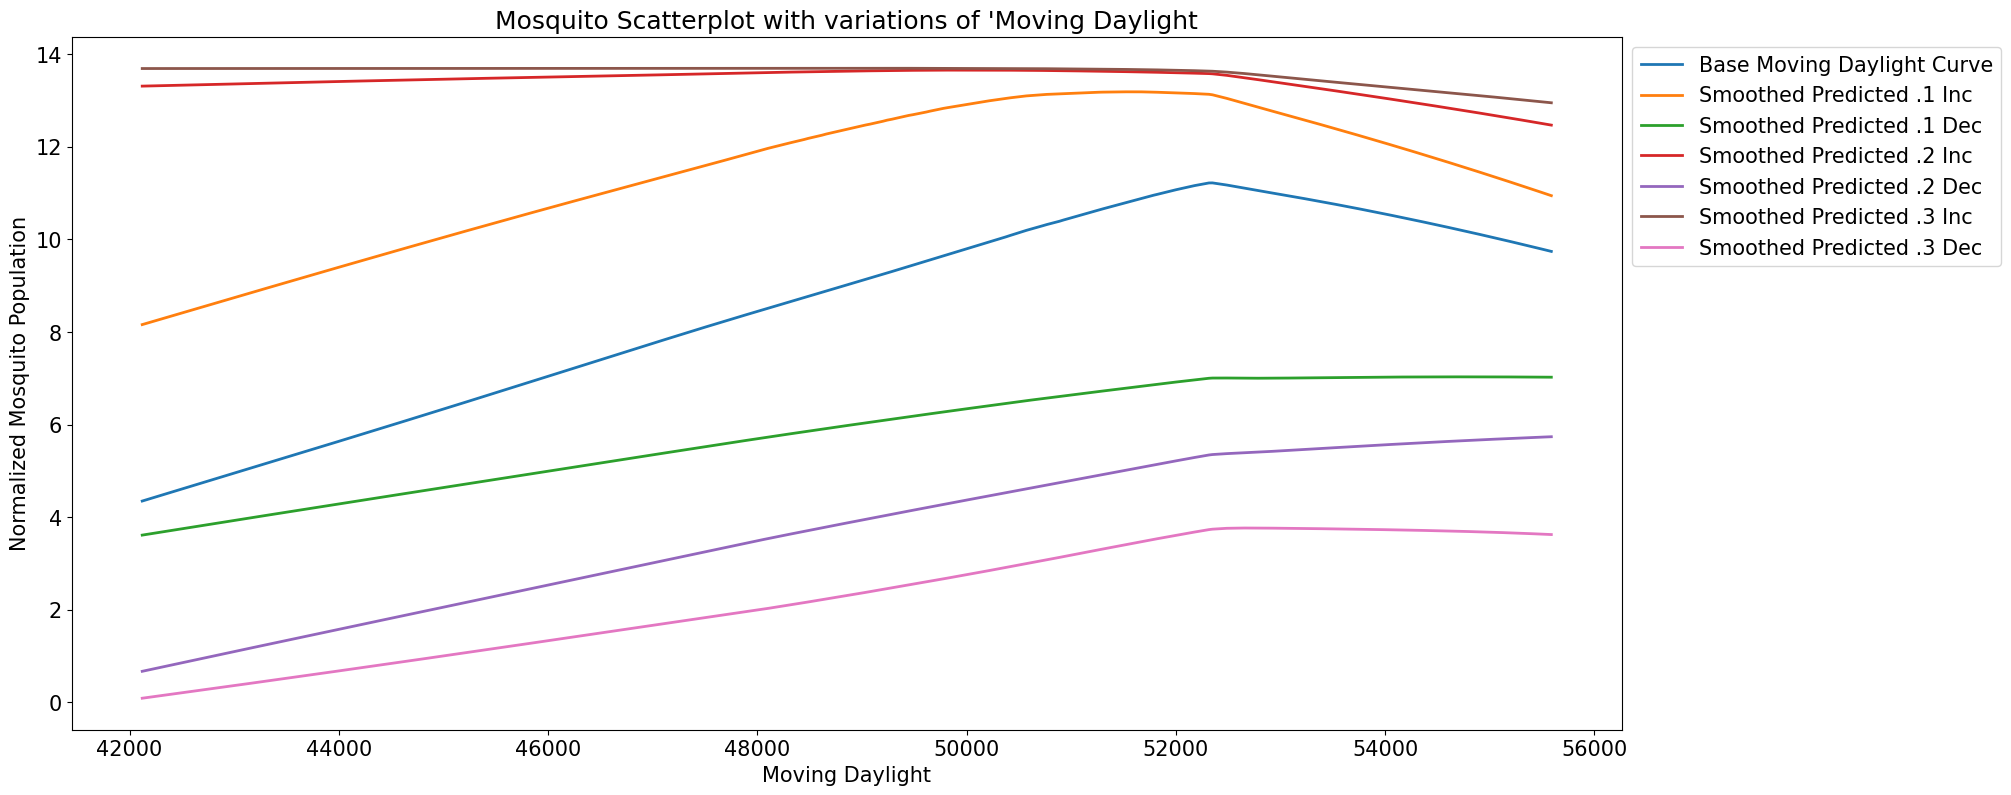

Evaluating model with variations of 'Moving Mean Temp':
36/36 [==============================] - 0s 6ms/step


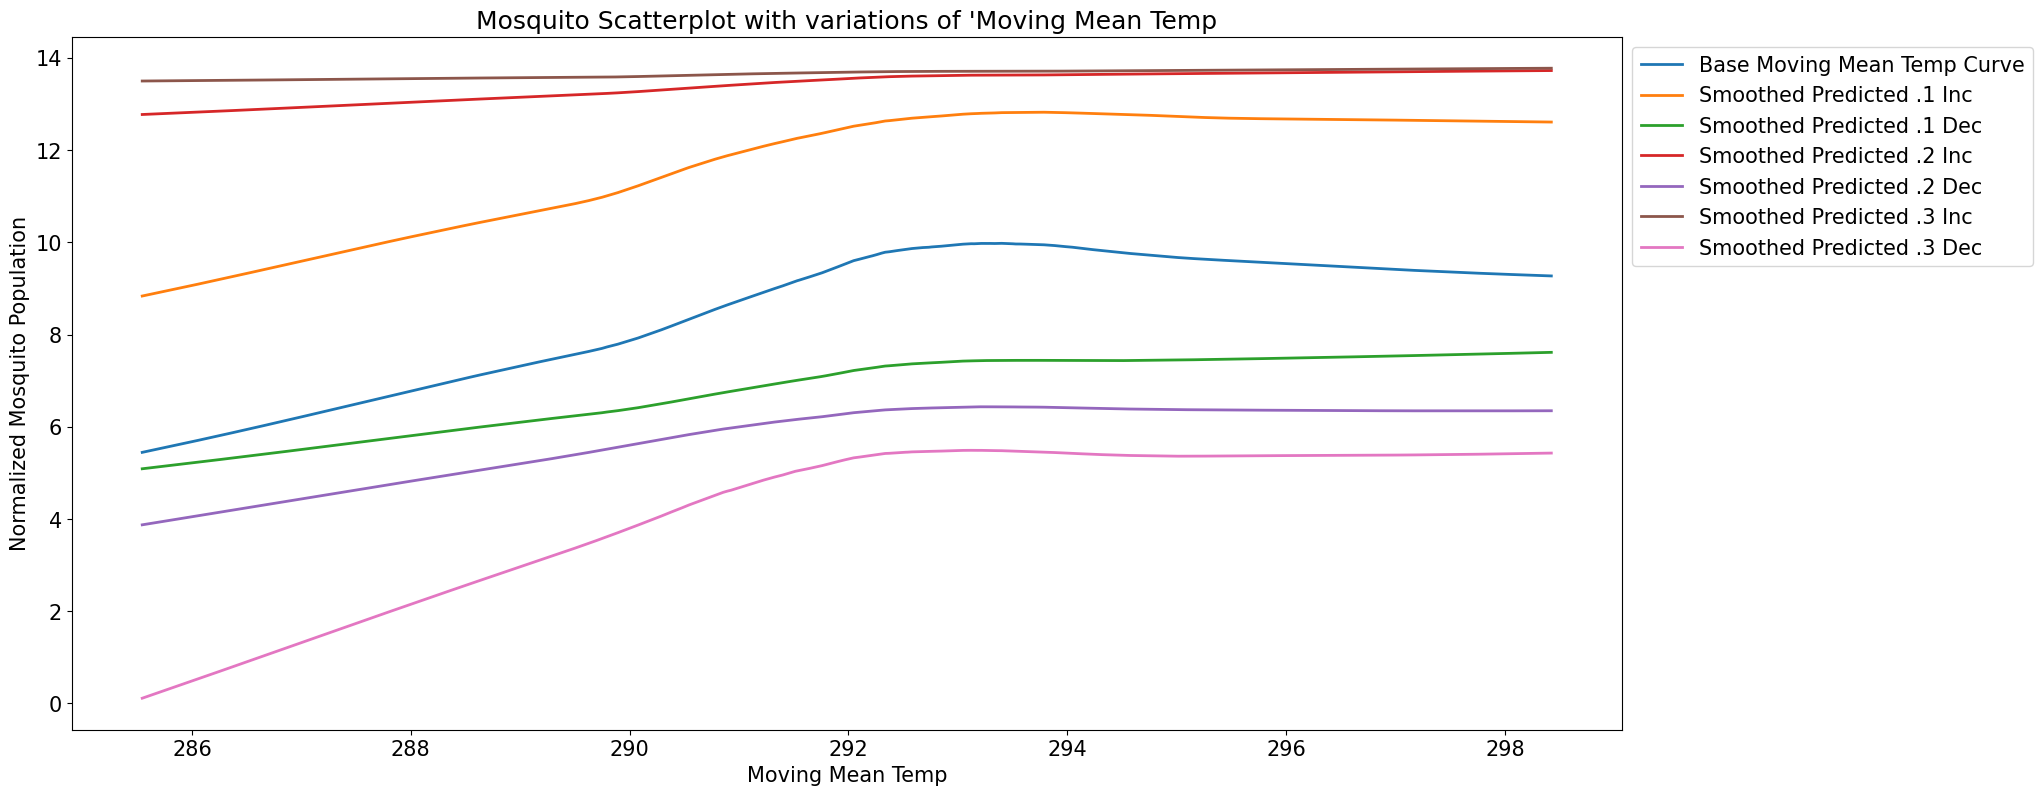

Evaluating model with variations of 'Moving Total Precip':
36/36 [==============================] - 0s 6ms/step


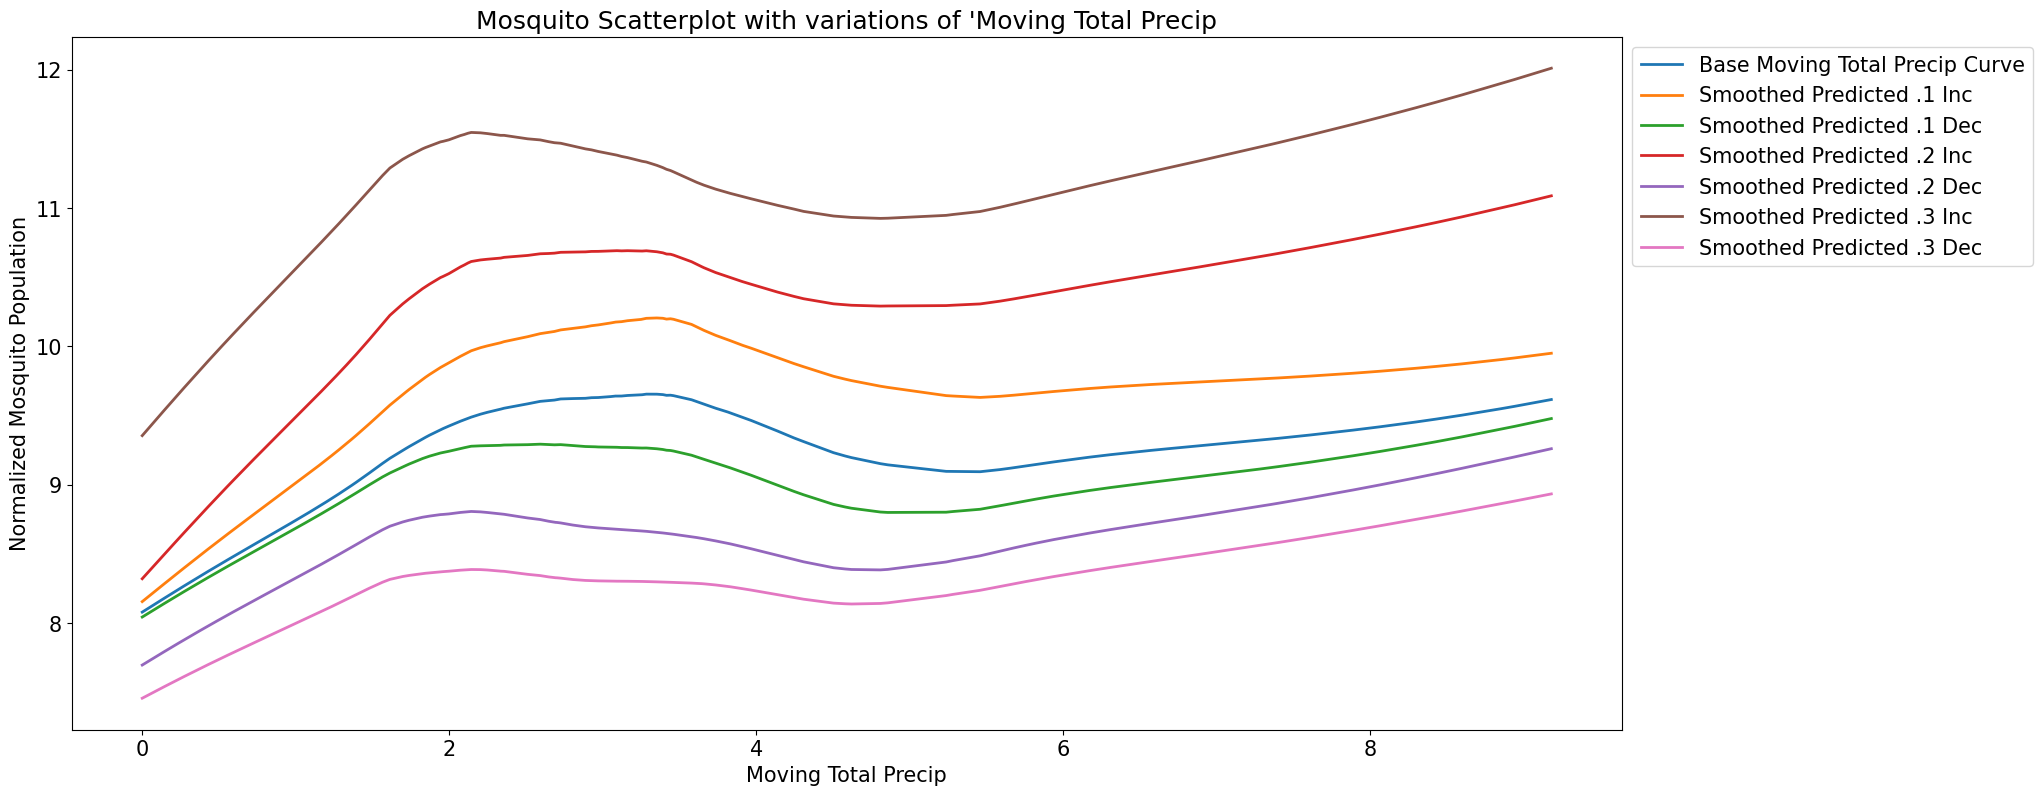

Evaluating model with variations of 'Moving LAI':
36/36 [==============================] - 0s 6ms/step


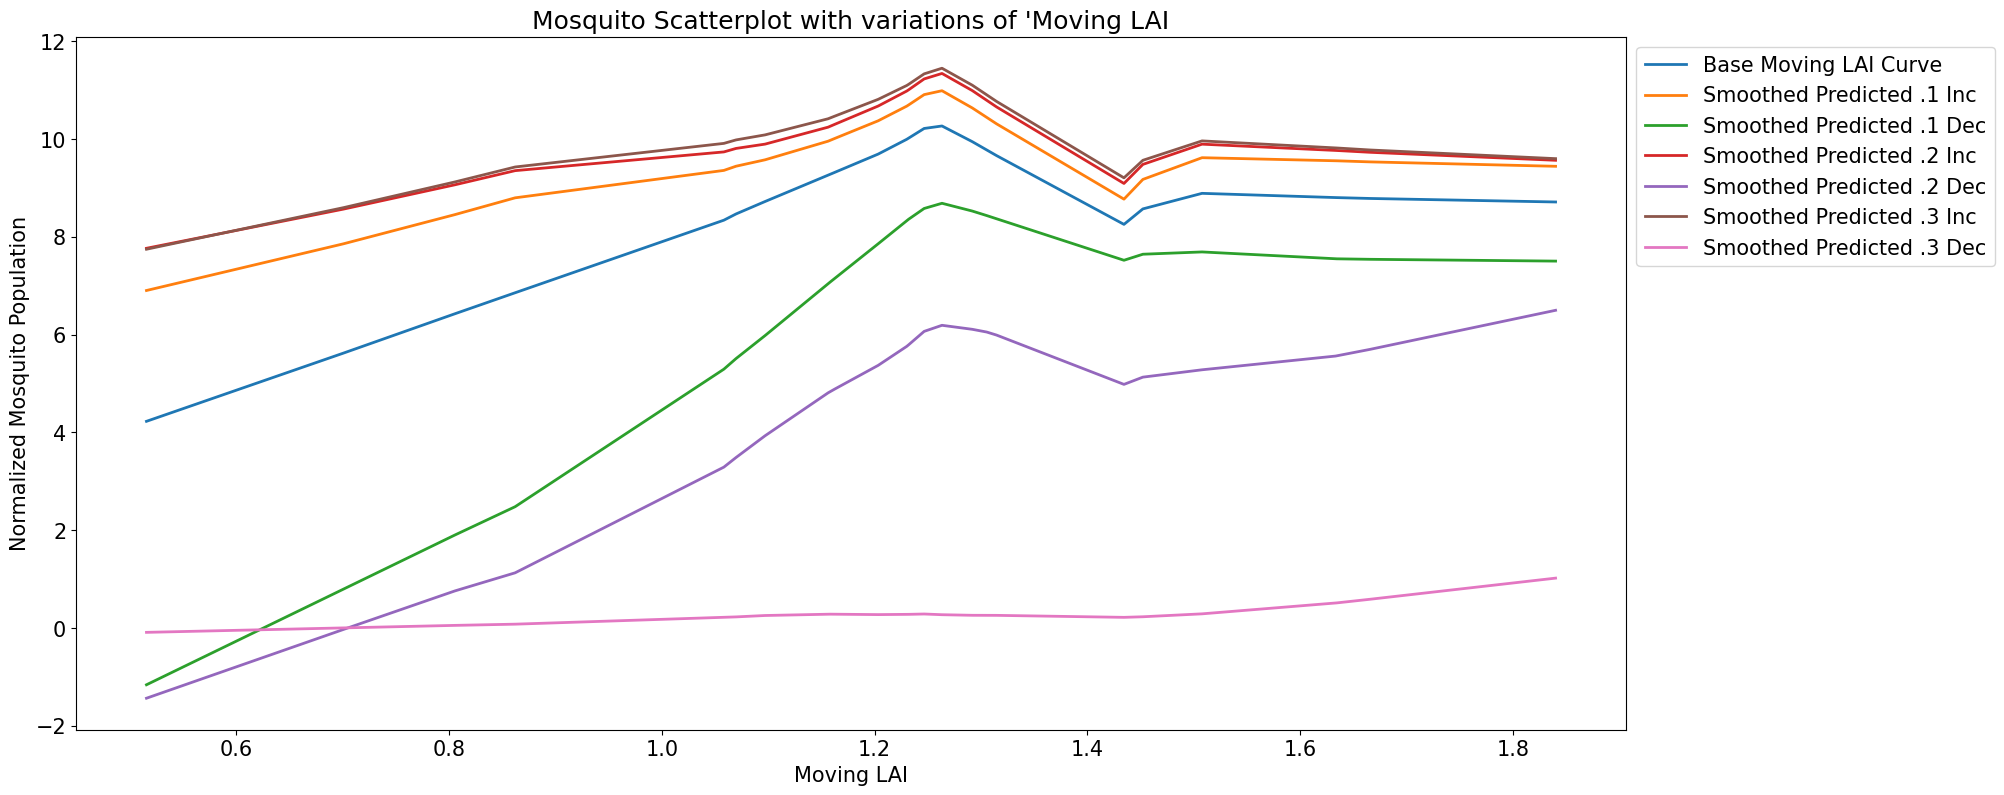

Evaluating model with variations of 'Moving Outflow (m^3/s)':
36/36 [==============================] - 0s 8ms/step


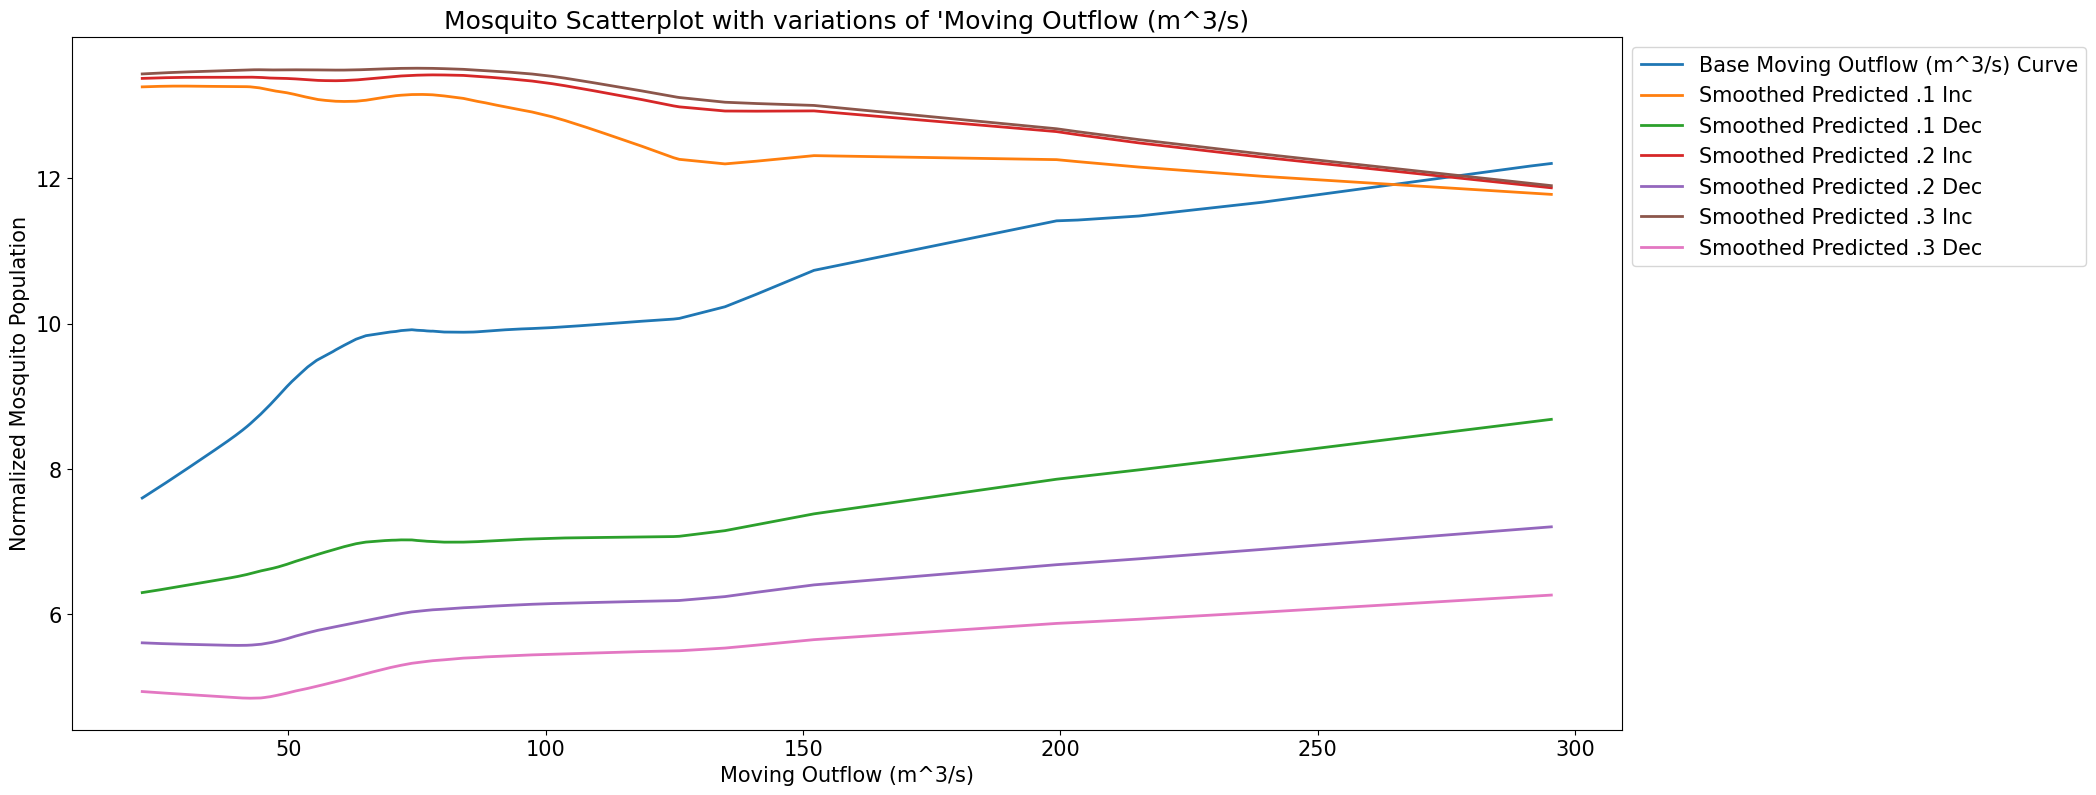

Evaluating model with variations of 'Moving SM':
36/36 [==============================] - 0s 6ms/step


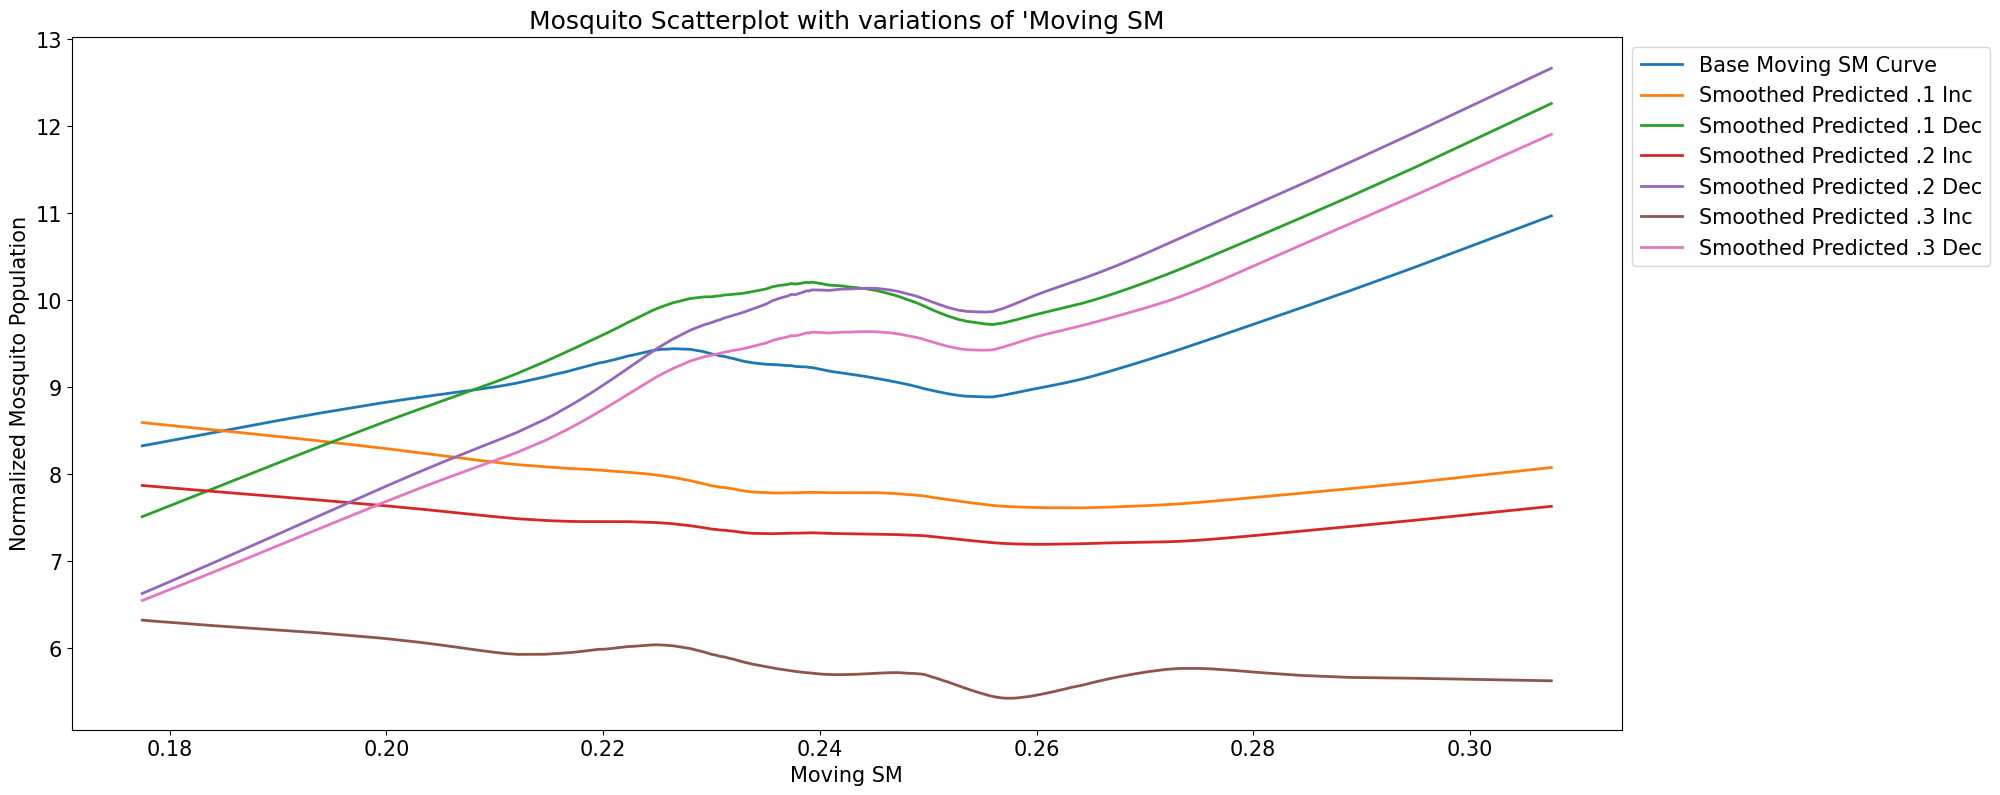

Evaluating model with variations of 'Timeskip':
36/36 [==============================] - 0s 5ms/step


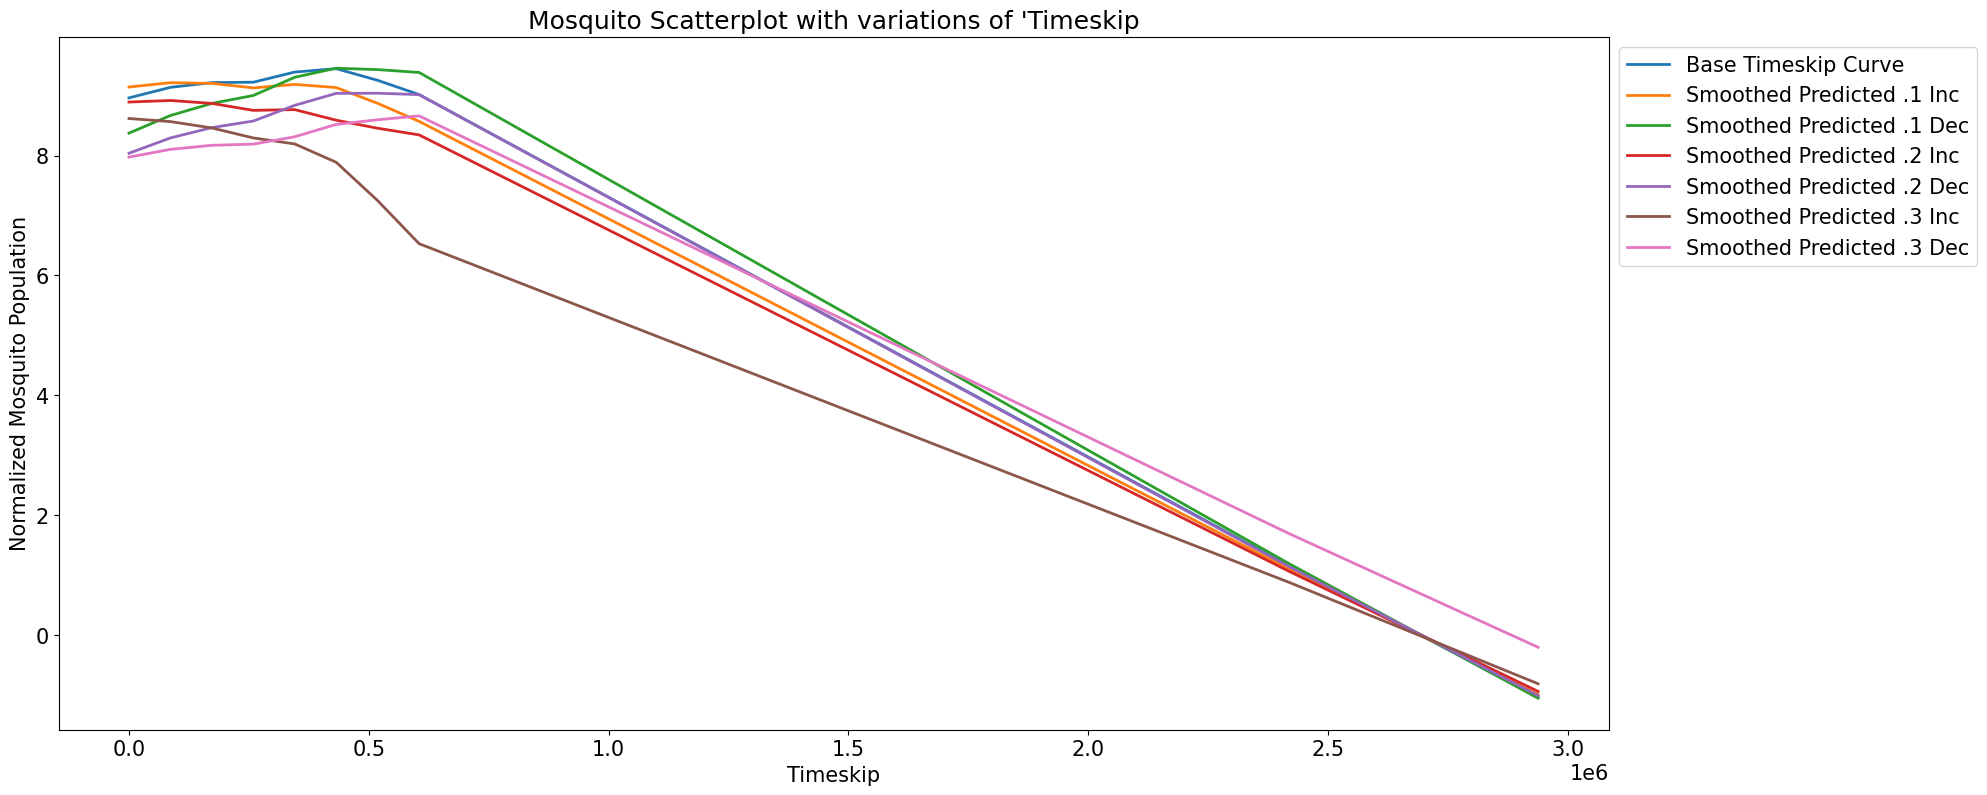

In [20]:
# Plots of how the output would change throughout the test dataset under variations in feature variables. Feature value vs Mosquito simulated population
for i, feature in enumerate(cols):
    # Starting the feature changing - we can see what feature is being worked on at a time
    print(f"Evaluating model with variations of '{feature}':")
    feature_data_dec_30,feature_data_inc_30,feature_data_dec_20,feature_data_inc_20,feature_data,feature_data_inc_10,feature_data_dec_10 = get_feature_data(original_test_data, i)
    (feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10) = normalize_features(
        feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10)

    # Running the LSTM here and getting the data into a df
    ypred_avg = regressor.predict(feature_data)
    ypred_avg_inc_10 = regressor.predict(feature_data_inc_10)
    ypred_avg_dec_10 = regressor.predict(feature_data_dec_10)
    ypred_avg_inc_20 = regressor.predict(feature_data_inc_20)
    ypred_avg_dec_20 = regressor.predict(feature_data_dec_20)
    ypred_avg_inc_30 = regressor.predict(feature_data_inc_30)
    ypred_avg_dec_30 = regressor.predict(feature_data_dec_30)

    TestNo0 = pd.DataFrame()
    TestNo0['Actual Mosquito Data'] = ytest.flatten()
    TestNo0['Mosquito Predictions Average'] = ypred_avg.flatten()
    TestNo0['Mosquito Predictions .1 Inc'] = ypred_avg_inc_10.flatten()
    TestNo0['Mosquito Predictions .1 Dec'] = ypred_avg_dec_10.flatten()
    TestNo0['Mosquito Predictions .2 Inc'] = ypred_avg_inc_20.flatten()
    TestNo0['Mosquito Predictions .2 Dec'] = ypred_avg_dec_20.flatten()
    TestNo0['Mosquito Predictions .3 Inc'] = ypred_avg_inc_30.flatten()
    TestNo0['Mosquito Predictions .3 Dec'] = ypred_avg_dec_30.flatten()

    # Matching the appropriate timeframe. Also, observational data is set up as the specific feature data.
    TestNo0['Observational Data'] = ObservedDataset.iloc[2290:3435][feature].reset_index(drop=True) 
    TestNo0['Date'] = ObservedDataset.iloc[2290:3435]['Date'].reset_index(drop=True)
    TestNo0 = TestNo0[TestNo0['Actual Mosquito Data'] != 0]
    TestNo0 = TestNo0.sort_values(by='Observational Data')

    # Plotting mosquito predictions vs observational data 
    plt.close('all')
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions Average'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label=f'Base {feature} Curve', linewidth=2)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted .1 Inc', linewidth=2)
    
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted .1 Dec', linewidth=2)
    
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted .2 Inc', linewidth=2)
    
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted .2 Dec', linewidth=2)
      
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted .3 Inc', linewidth=2)
    
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted .3 Dec', linewidth=2)

    plt.title(f"Mosquito Scatterplot with variations of '{feature}")
    plt.ylabel('Normalized Mosquito Population')
    plt.xlabel(f'{feature}')
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.show()

Evaluating model with variations of 'Moving Daylight':
7/7 [==============================] - 0s 5ms/step


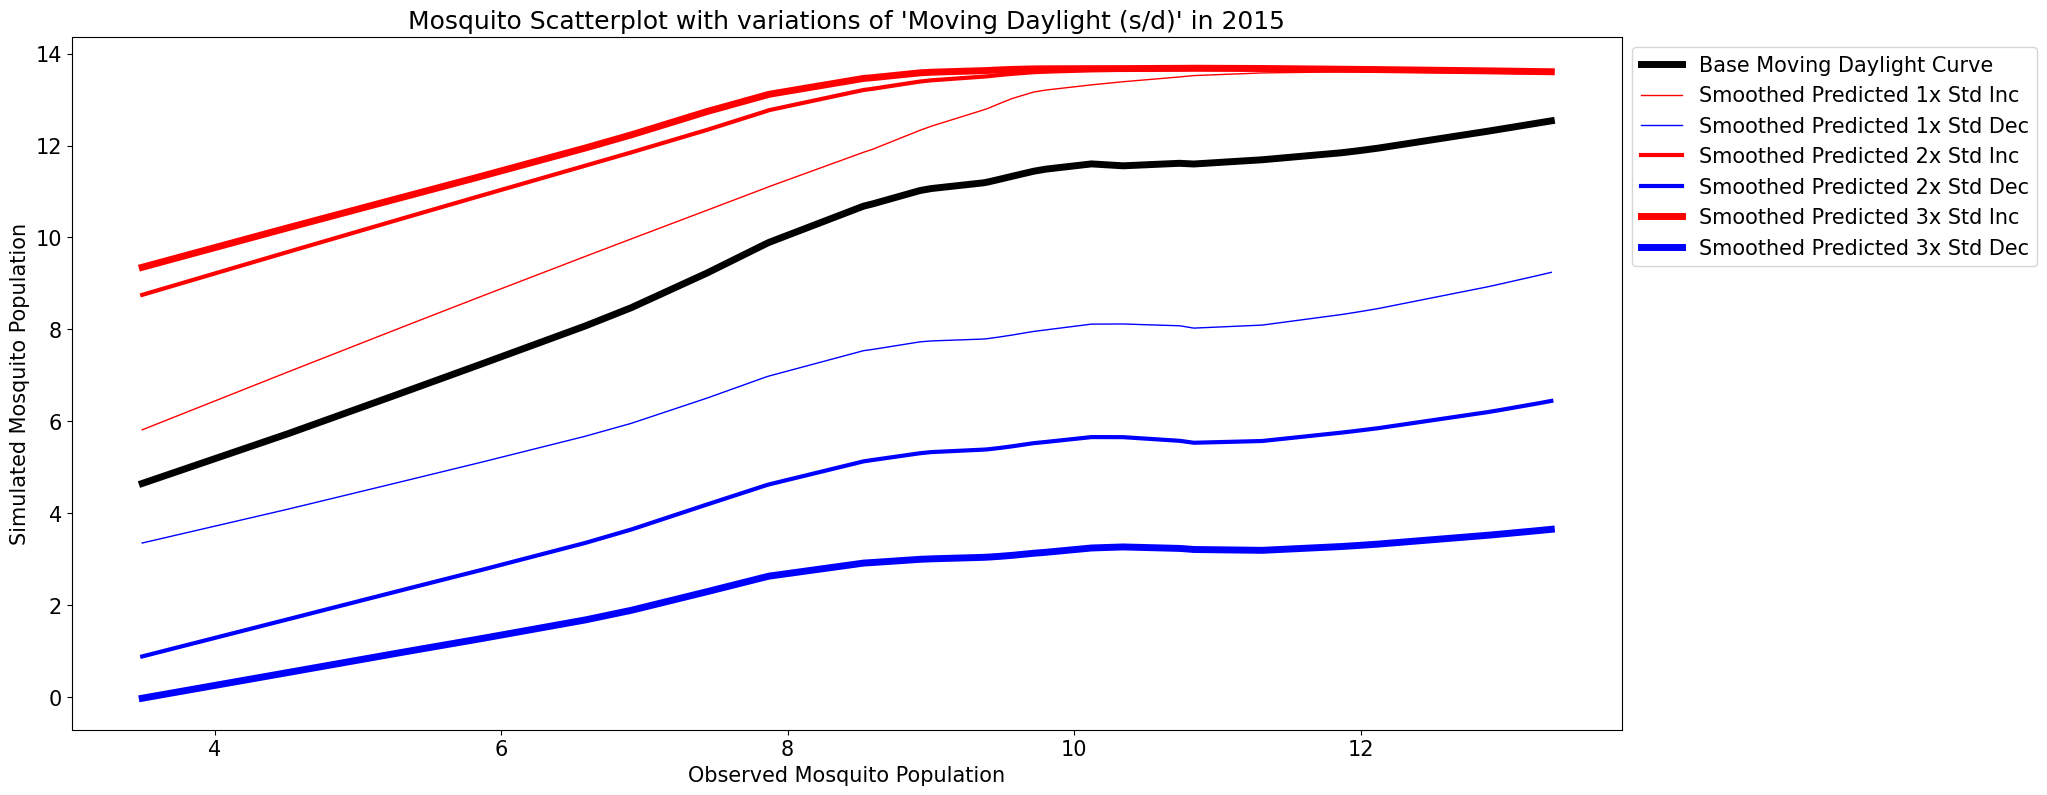

Evaluating model with variations of 'Moving Mean Temp':
7/7 [==============================] - 0s 5ms/step


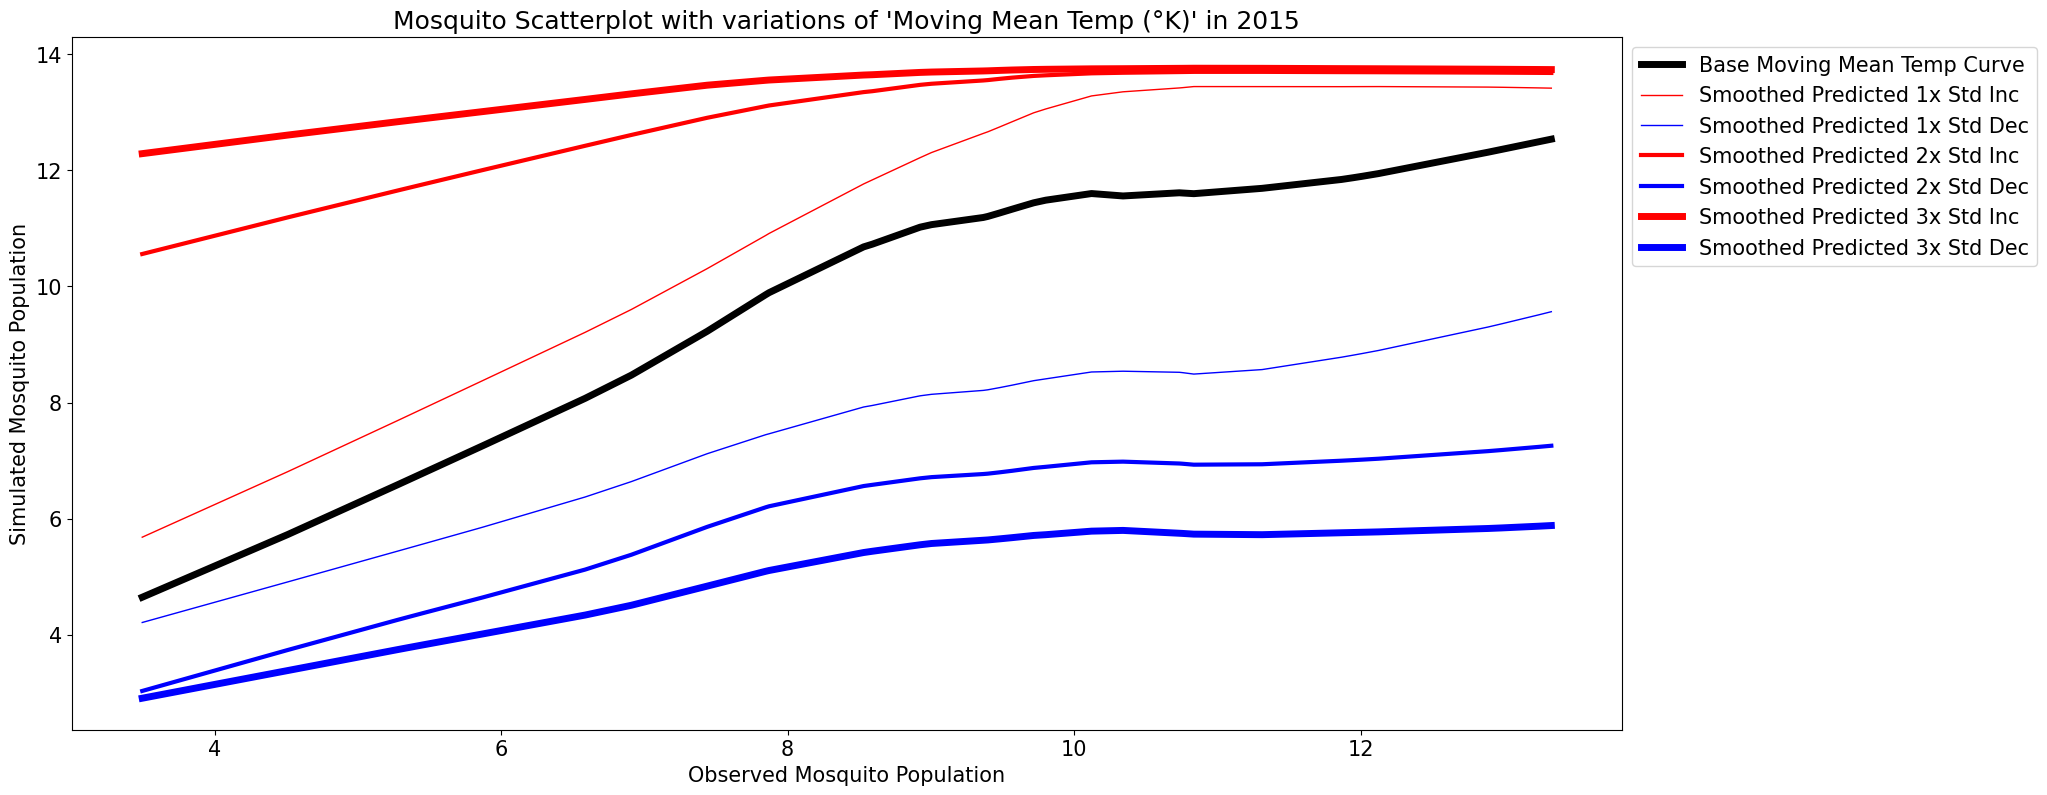

Evaluating model with variations of 'Moving Total Precip':
7/7 [==============================] - 0s 5ms/step


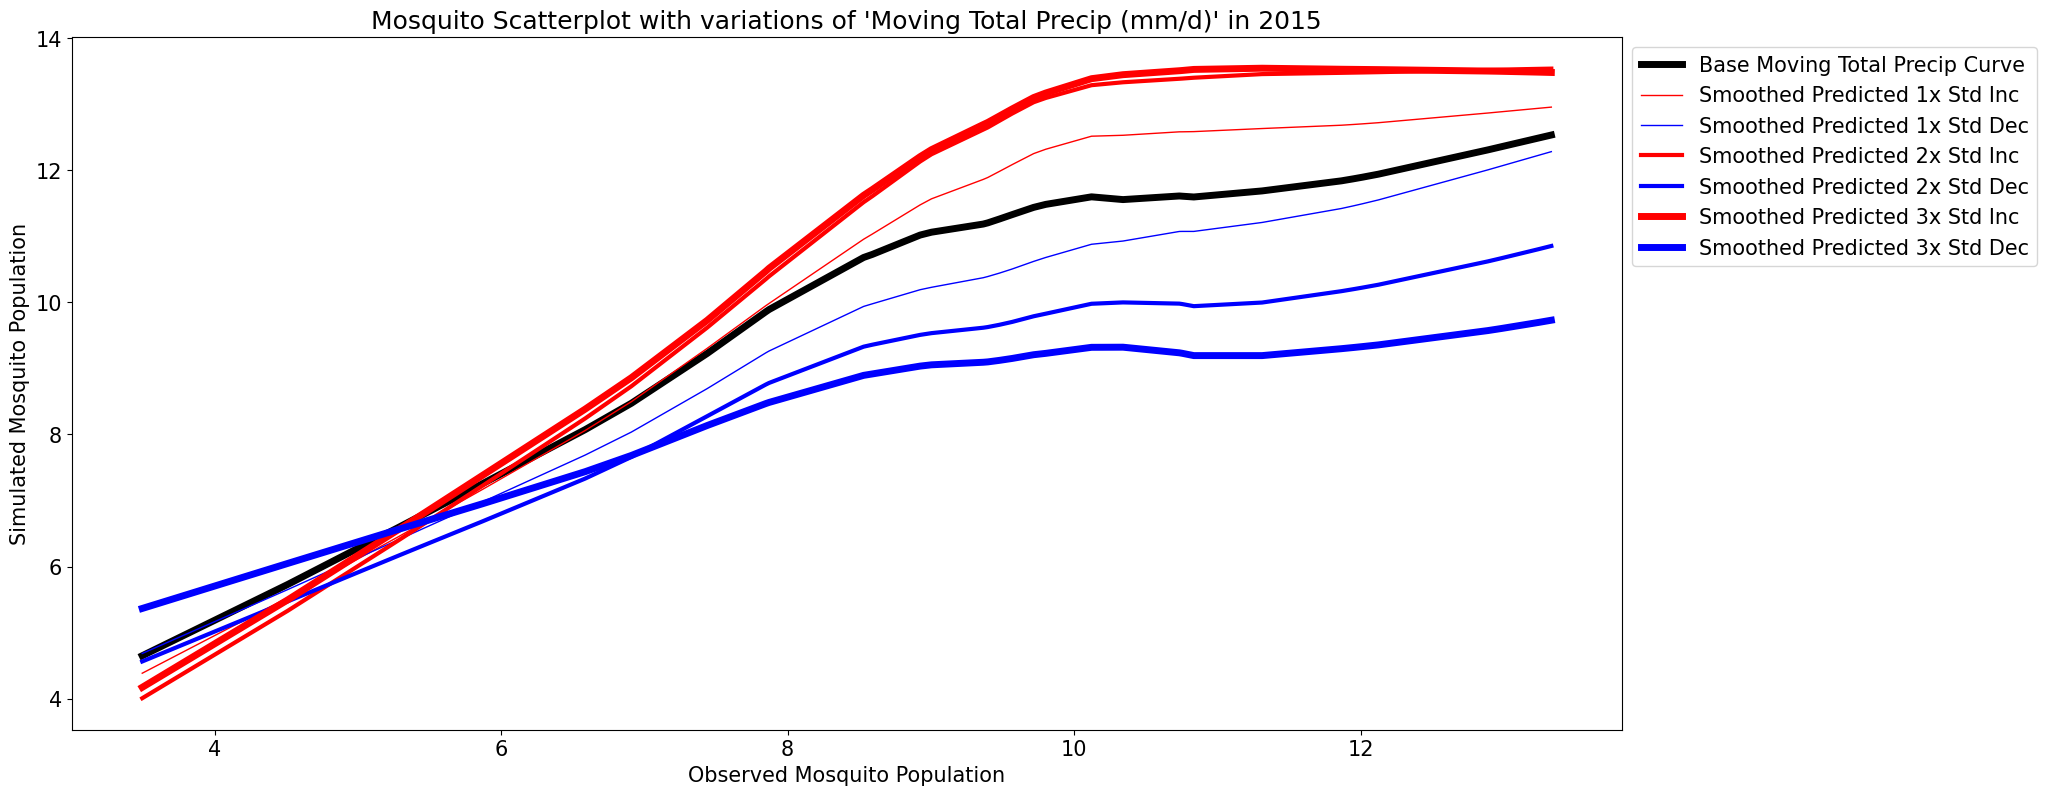

Evaluating model with variations of 'Moving LAI':
7/7 [==============================] - 0s 5ms/step


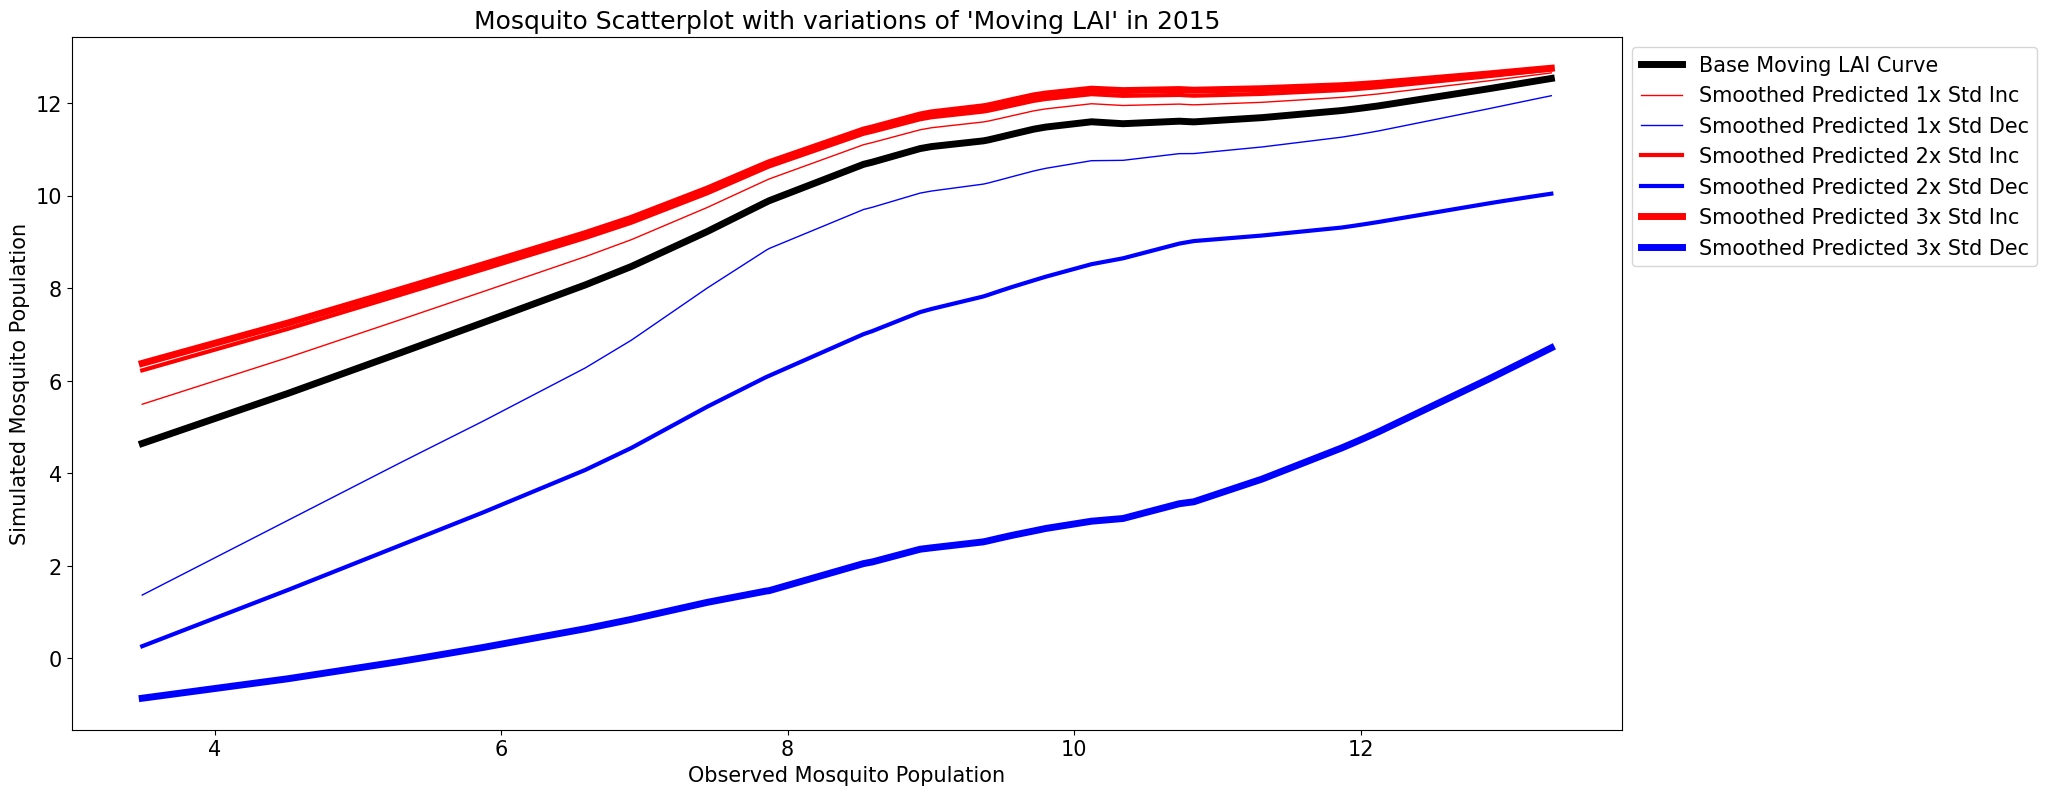

Evaluating model with variations of 'Moving Outflow (m^3/s)':
7/7 [==============================] - 0s 5ms/step


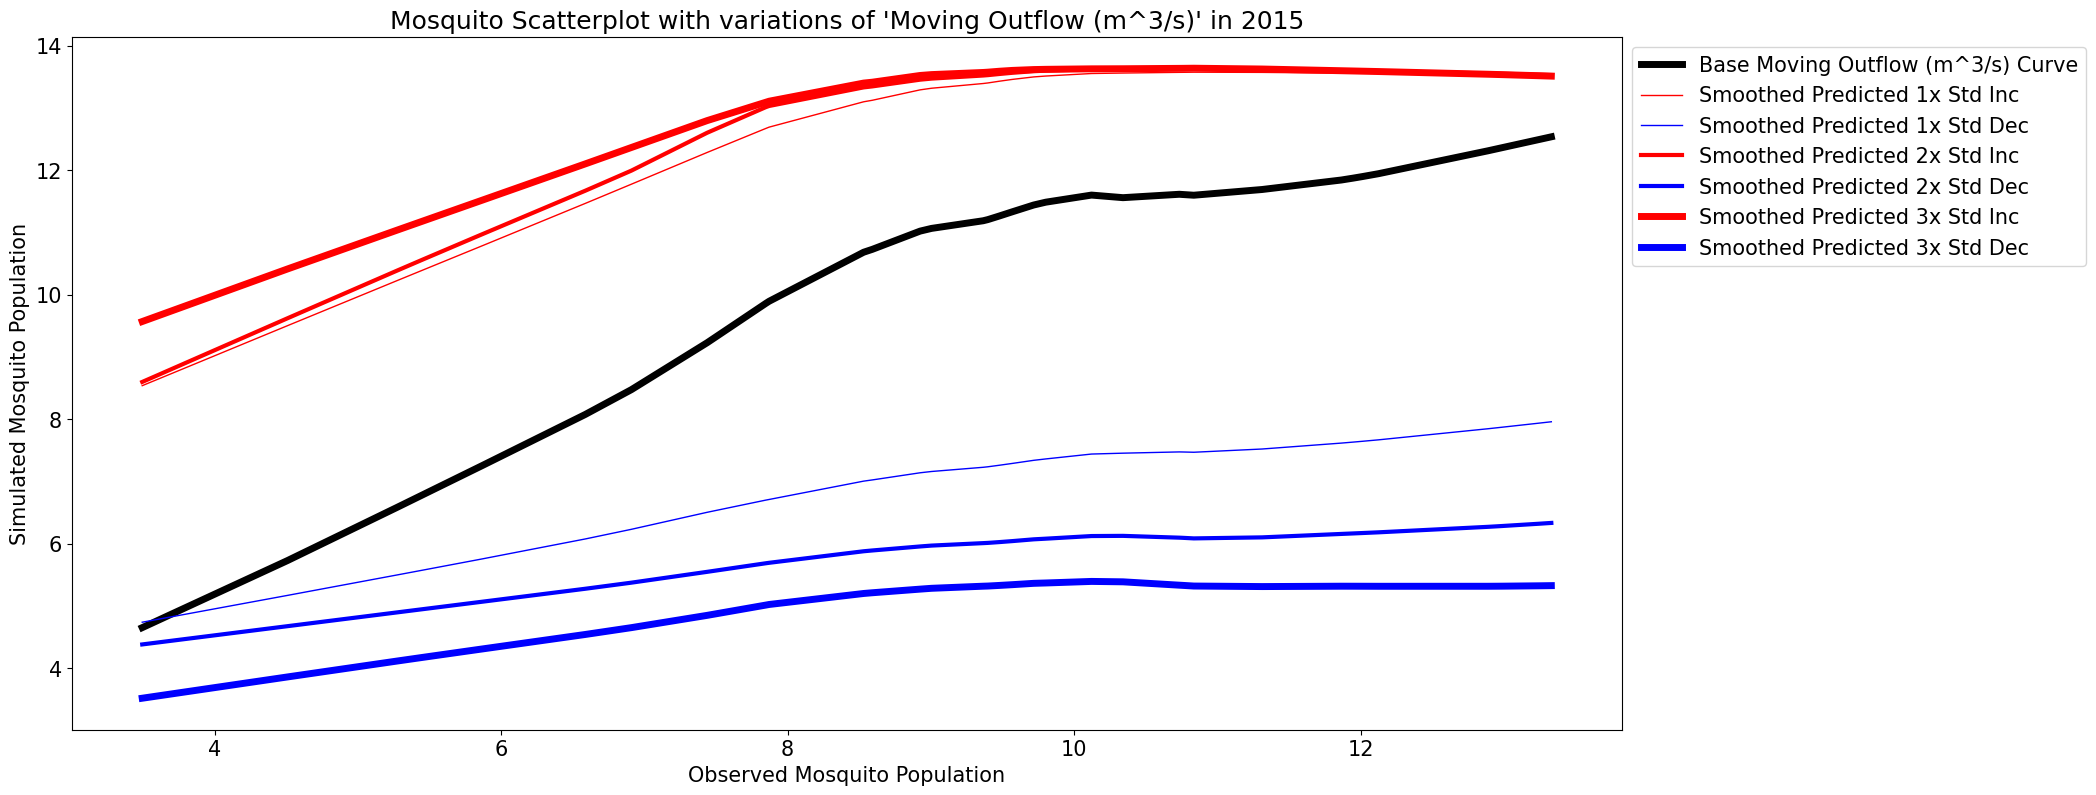

Evaluating model with variations of 'Moving SM':
7/7 [==============================] - 0s 6ms/step


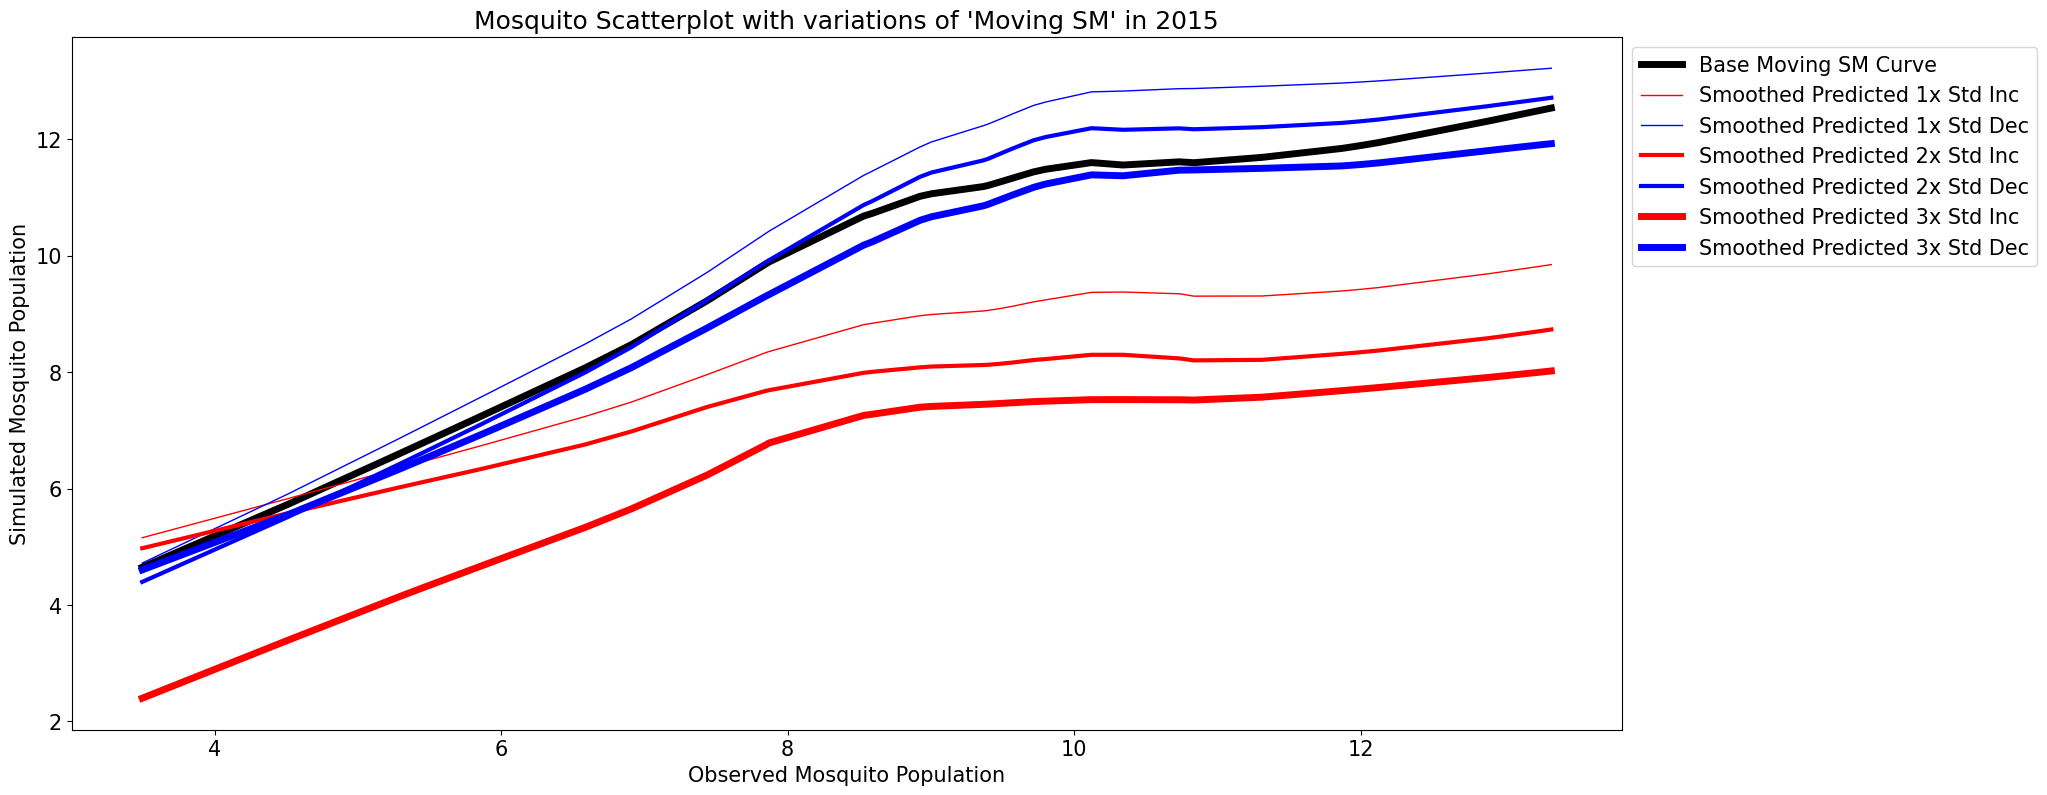

Evaluating model with variations of 'Timeskip':
7/7 [==============================] - 0s 7ms/step


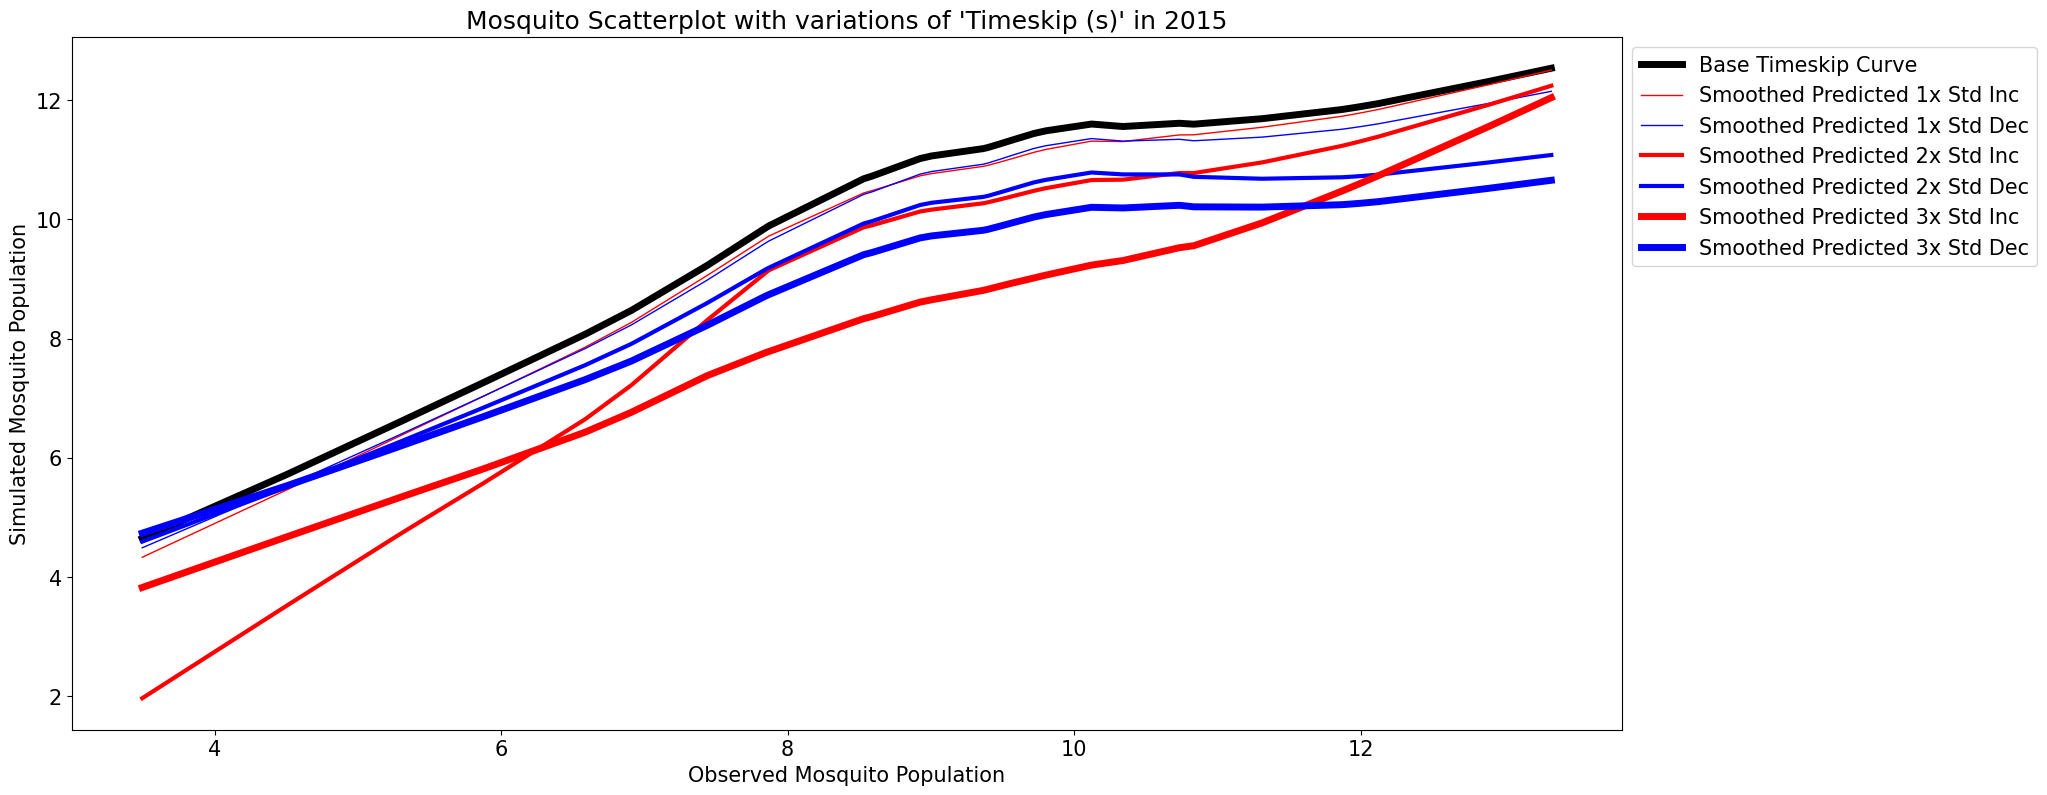

In [21]:
# Honing in a specific year for clarity of results. Plotting observed vs simulated mosquitoes to assess change more directly
SliceOfObs=ObservedDataset[ObservedDataset['Date'].dt.year==2015]
# Investigating for specific year
x_data = []
cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip','Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM','Timeskip']
units_dict = {'Moving Daylight': 's/d', 'Moving Mean Temp': '°K', 'Moving Total Precip': 'mm/d', 'Moving LAI': '', 'Moving Outflow (m^3/s)': '',
    'Moving SM': '', 'Timeskip': 's'}

# Getting values specifically for 2015
for _, row in SliceOfObs.iterrows():
    date = row['Date']
    mosquito_count = row['# of Mosquitoes Rolling']
    timeskip_value = row['Timeskip']
    start_date = date - pd.Timedelta(days=60)
    mask = (ActualObs['Date'] > start_date) & (ActualObs['Date'] <= date)
    subset_ActualObs = ActualObs[mask].copy()
    if len(subset_ActualObs) == 60:
        subset_ActualObs['Timeskip'] = timeskip_value
        subset_values = subset_ActualObs[cols].values
        x_data.append(subset_values)
        
x_data = np.array(x_data)
original_test_data = x_data.copy()
metrics = {}
results = {}
for i, feature in enumerate(cols):
    # Similar to previous box
    print(f"Evaluating model with variations of '{feature}':")
    feature_data_dec_30,feature_data_inc_30,feature_data_dec_20,feature_data_inc_20,feature_data,feature_data_inc_10,feature_data_dec_10 = get_feature_data(original_test_data, i)
    (feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10) = normalize_features(
        feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10)
    
    ypred_avg = regressor.predict(feature_data)
    ypred_avg_inc_10 = regressor.predict(feature_data_inc_10)
    ypred_avg_dec_10 = regressor.predict(feature_data_dec_10)
    ypred_avg_inc_20 = regressor.predict(feature_data_inc_20)
    ypred_avg_dec_20 = regressor.predict(feature_data_dec_20)
    ypred_avg_inc_30 = regressor.predict(feature_data_inc_30)
    ypred_avg_dec_30 = regressor.predict(feature_data_dec_30)

    # Got the obs data specifically for 2015!
    New=pd.DataFrame()
    New=ObservedDataset[ObservedDataset['Date'].dt.year==2015]
    NewMosq=New[['# of Mosquitoes Rolling','Date']].reset_index(drop=True)

    # Observational data is set as the actual mosquito rolling data
    TestNo0 = pd.DataFrame()
    TestNo0['Actual Mosquito Data'] = New['# of Mosquitoes Rolling'] 
    TestNo0['Mosquito Predictions Average'] = ypred_avg.flatten()
    TestNo0['Mosquito Predictions .1 Inc'] = ypred_avg_inc_10.flatten()
    TestNo0['Mosquito Predictions .1 Dec'] = ypred_avg_dec_10.flatten()
    TestNo0['Mosquito Predictions .2 Inc'] = ypred_avg_inc_20.flatten()
    TestNo0['Mosquito Predictions .2 Dec'] = ypred_avg_dec_20.flatten()
    TestNo0['Mosquito Predictions .3 Inc'] = ypred_avg_inc_30.flatten()
    TestNo0['Mosquito Predictions .3 Dec'] = ypred_avg_dec_30.flatten()
    TestNo0['Observational Data'] = New['# of Mosquitoes Rolling'] 
    TestNo0 = TestNo0[TestNo0['Actual Mosquito Data'] != 0]
    
    results[feature] = {"Modeled Avg Density": TestNo0['Mosquito Predictions Average'].mean(),
        "Modeled .1 Inc Density": TestNo0['Mosquito Predictions .1 Inc'].mean(), "Modeled .1 Dec Density": TestNo0['Mosquito Predictions .1 Dec'].mean(),
        "Modeled .2 Inc Density": TestNo0['Mosquito Predictions .2 Inc'].mean(), "Modeled .2 Dec Density": TestNo0['Mosquito Predictions .2 Dec'].mean(),
        "Modeled .3 Inc Density": TestNo0['Mosquito Predictions .3 Inc'].mean(), "Modeled .3 Dec Density": TestNo0['Mosquito Predictions .3 Dec'].mean(),
        "Observed Density": TestNo0['Actual Mosquito Data'].mean()}

    # Modeling - Seeing actual vs simulated mosquito populations
    plt.close('all')
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions Average'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label=f'Base {feature} Curve', color='black', linewidth=5)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 1x Std Inc', color='red', linewidth=1)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 1x Std Dec', color='blue', linewidth=1)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 2x Std Inc', color='red', linewidth=3)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 2x Std Dec', color='blue', linewidth=3)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 3x Std Inc', color='red', linewidth=5)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 3x Std Dec', color='blue', linewidth=5)

    unit_str = f" ({units_dict[feature]})" if units_dict[feature] != '' else ''
    plt.title(f"Mosquito Scatterplot with variations of '{feature}{unit_str}' in 2015")

    plt.ylabel('Simulated Mosquito Population')
    plt.xlabel('Observed Mosquito Population')
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.show()

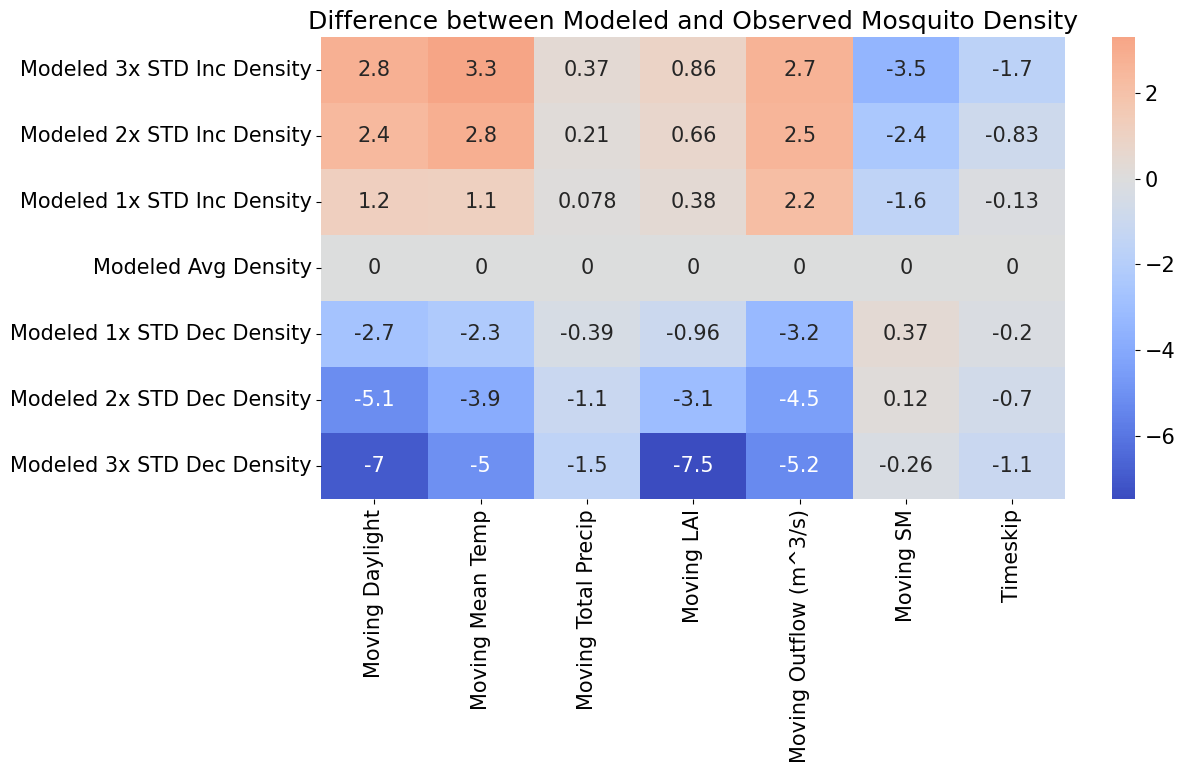

In [22]:
# Creating a comprehensive heatmap for average variable differences between average and changed feature mosquito simulation
df_differences = pd.DataFrame(index=cols)
intervals = [0.3, 0.2, 0.1] 
for feature in cols:
    diff_key = "Modeled Avg Density"
    df_differences.loc[feature, diff_key] = results[feature][diff_key] - results[feature]["Modeled Avg Density"] #The difference for avg
    # Diff for the inc/dec
    for interval in intervals:
        inc_key = f"Modeled .{int(interval*10)} Inc Density"
        dec_key = f"Modeled .{int(interval*10)} Dec Density"
        df_differences.loc[feature, inc_key] = results[feature][inc_key] - results[feature]["Modeled Avg Density"]
        df_differences.loc[feature, dec_key] = results[feature][dec_key] - results[feature]["Modeled Avg Density"]

# Getting it in a more reasonable order
df_differences_transposed = df_differences.T
custom_order = ["Modeled .3 Inc Density", "Modeled .2 Inc Density", "Modeled .1 Inc Density", "Modeled Avg Density",
                "Modeled .1 Dec Density", "Modeled .2 Dec Density", "Modeled .3 Dec Density"]
label_mapping = {
    "Modeled .3 Inc Density": "Modeled 3x STD Inc Density", "Modeled .2 Inc Density": "Modeled 2x STD Inc Density",
    "Modeled .1 Inc Density": "Modeled 1x STD Inc Density", "Modeled Avg Density": "Modeled Avg Density",
    "Modeled .1 Dec Density": "Modeled 1x STD Dec Density", "Modeled .2 Dec Density": "Modeled 2x STD Dec Density",
    "Modeled .3 Dec Density": "Modeled 3x STD Dec Density"}

# Transposed for a better figure - have those labels on the Y
df_differences_ordered = df_differences_transposed.loc[custom_order]
df_differences_ordered = df_differences_ordered.rename(index=label_mapping)
plt.figure(figsize=(12, 6))
sns.heatmap(df_differences_ordered, annot=True, cmap="coolwarm", center=0)
plt.title("Difference between Modeled and Observed Mosquito Density")
plt.show()

Evaluating model with variations of 'Moving Daylight':
7/7 [==============================] - 0s 11ms/step


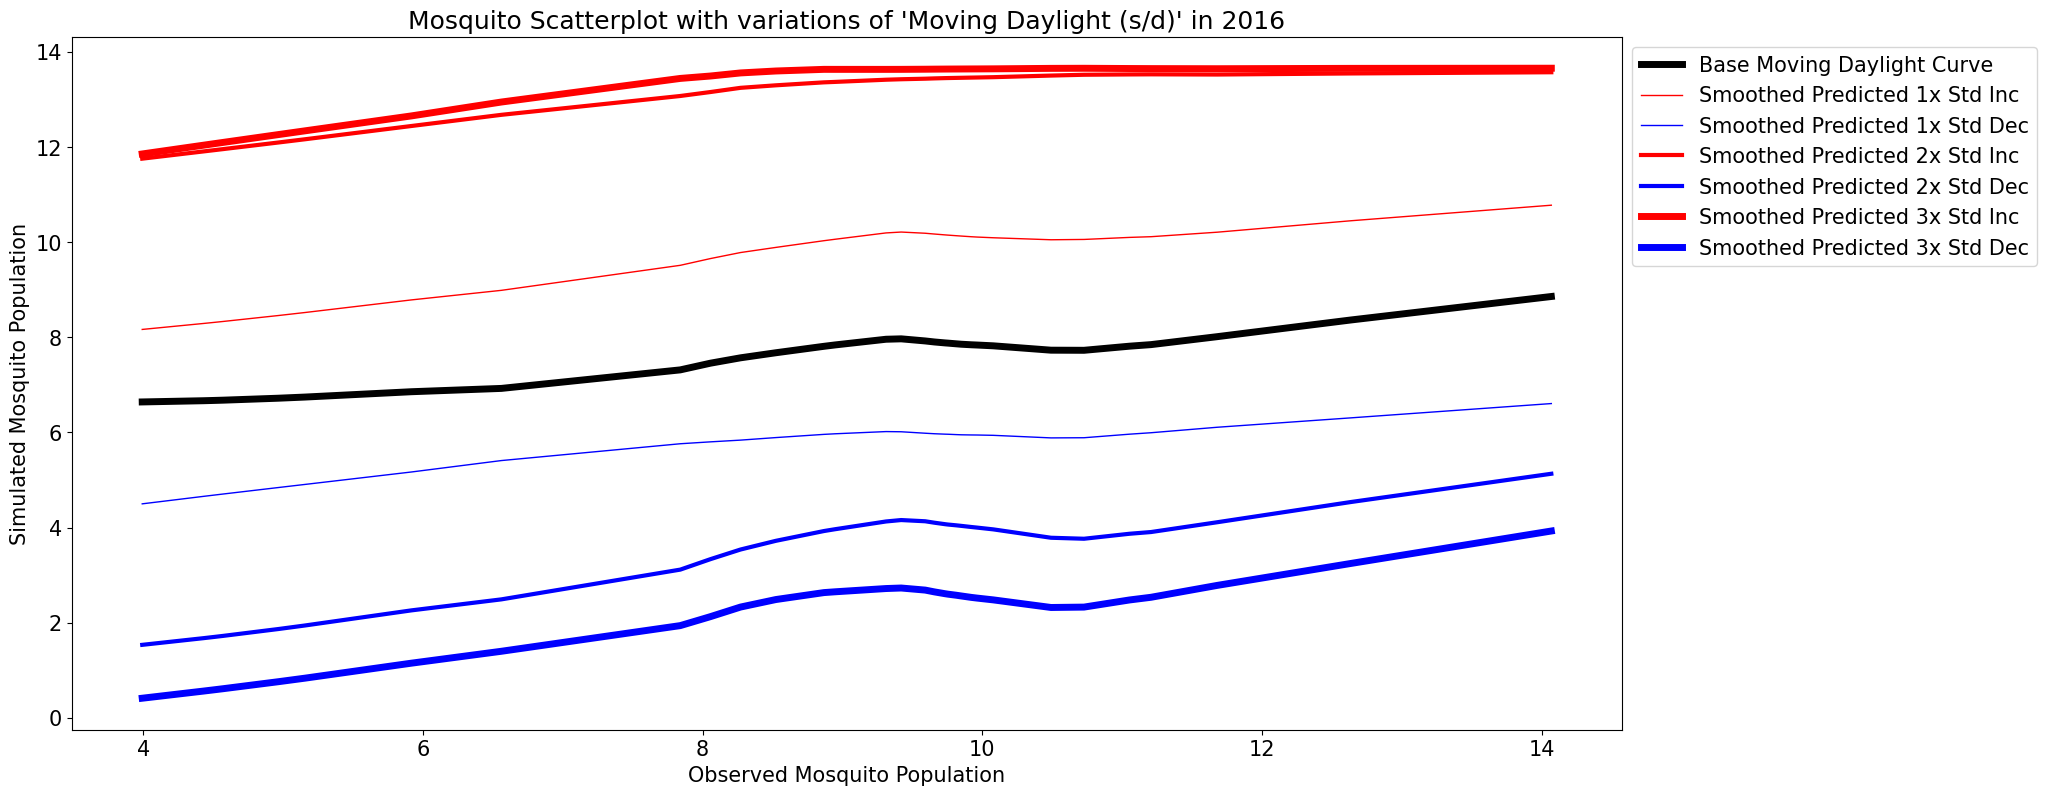

Evaluating model with variations of 'Moving Mean Temp':
7/7 [==============================] - 0s 10ms/step


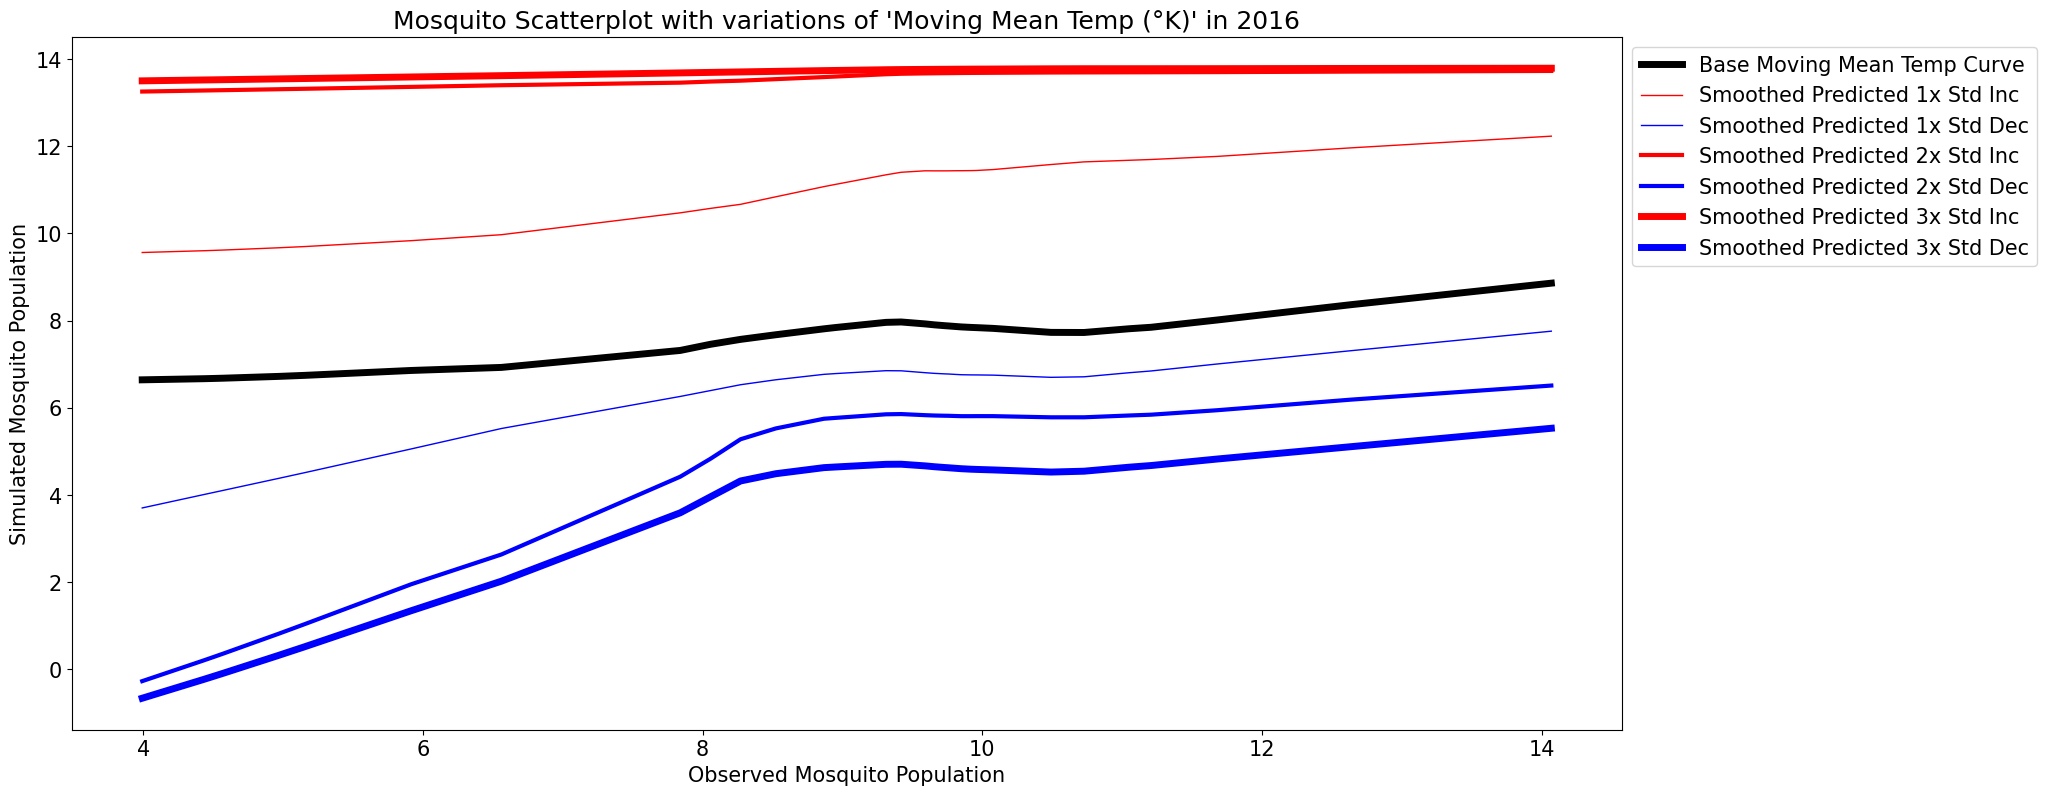

Evaluating model with variations of 'Moving Total Precip':
7/7 [==============================] - 0s 10ms/step


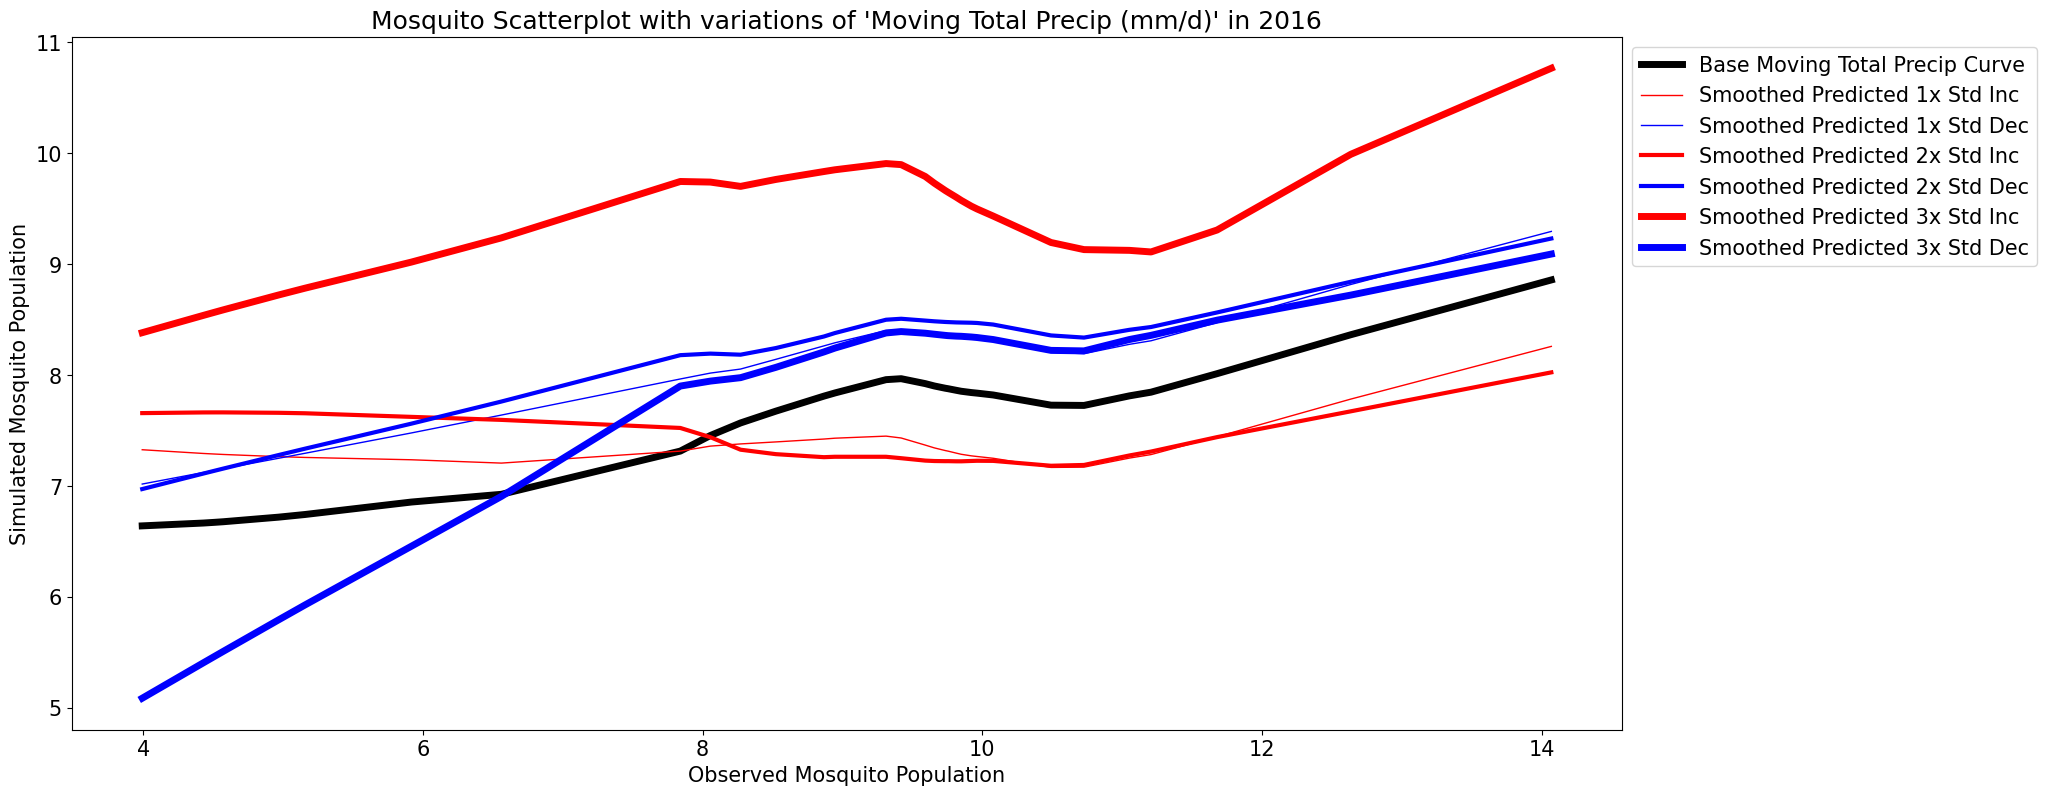

Evaluating model with variations of 'Moving LAI':
7/7 [==============================] - 0s 8ms/step


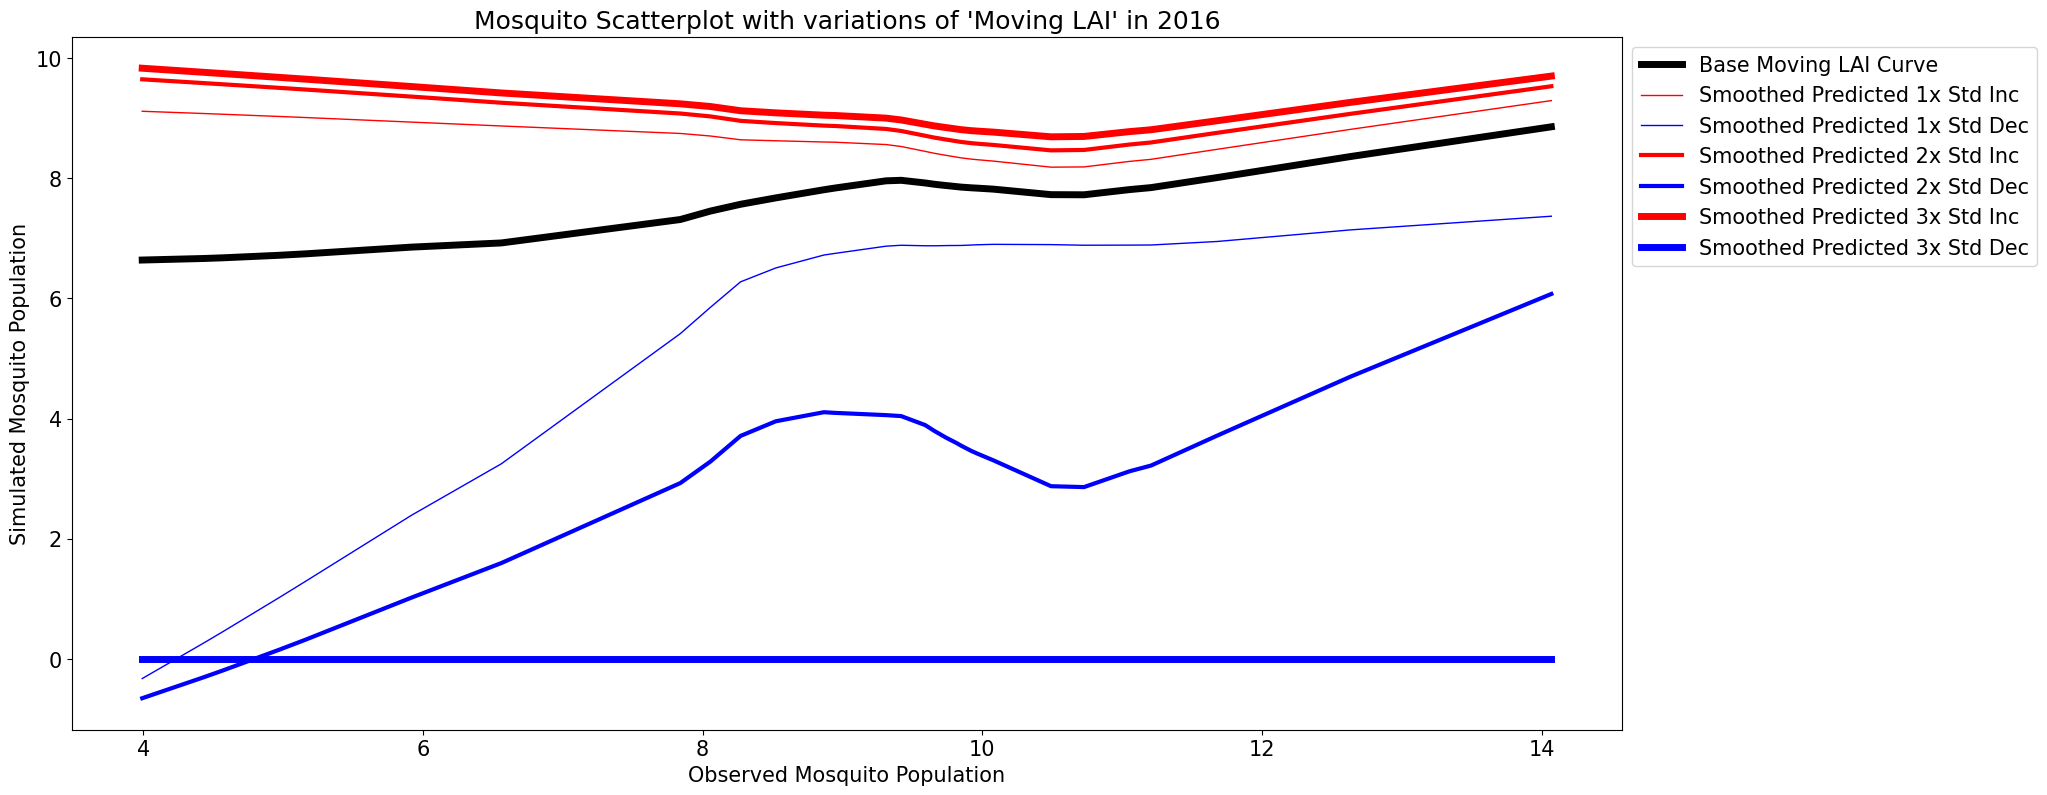

Evaluating model with variations of 'Moving Outflow (m^3/s)':
7/7 [==============================] - 0s 7ms/step


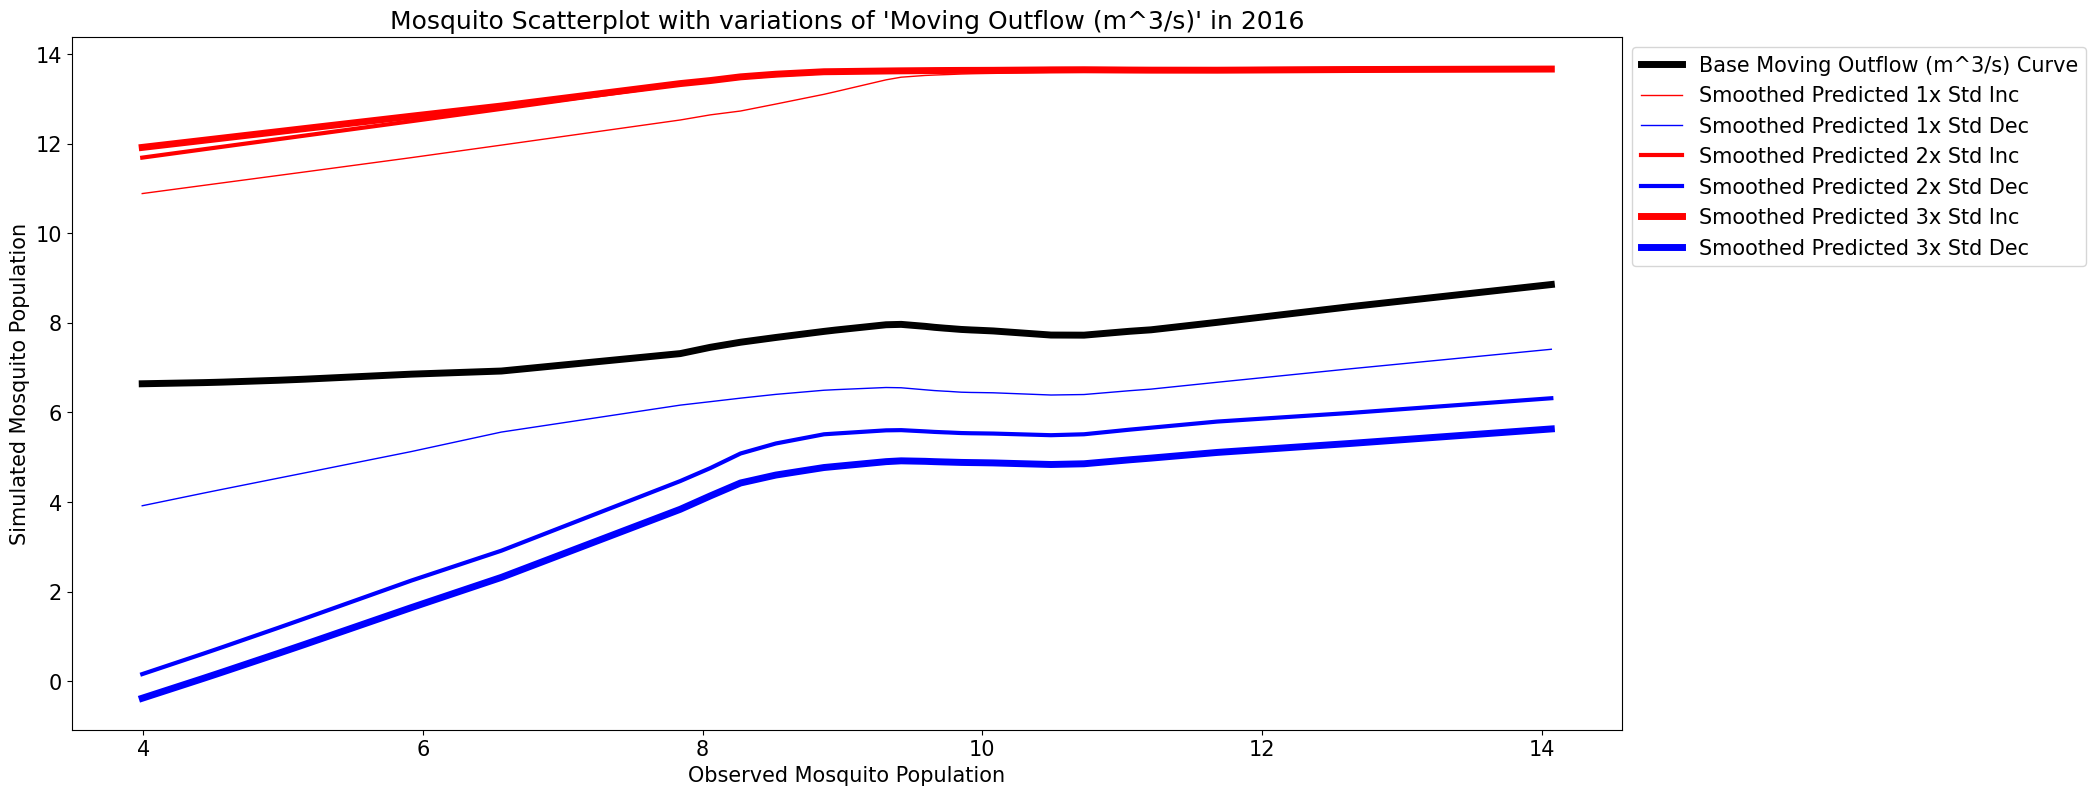

Evaluating model with variations of 'Moving SM':
7/7 [==============================] - 0s 6ms/step


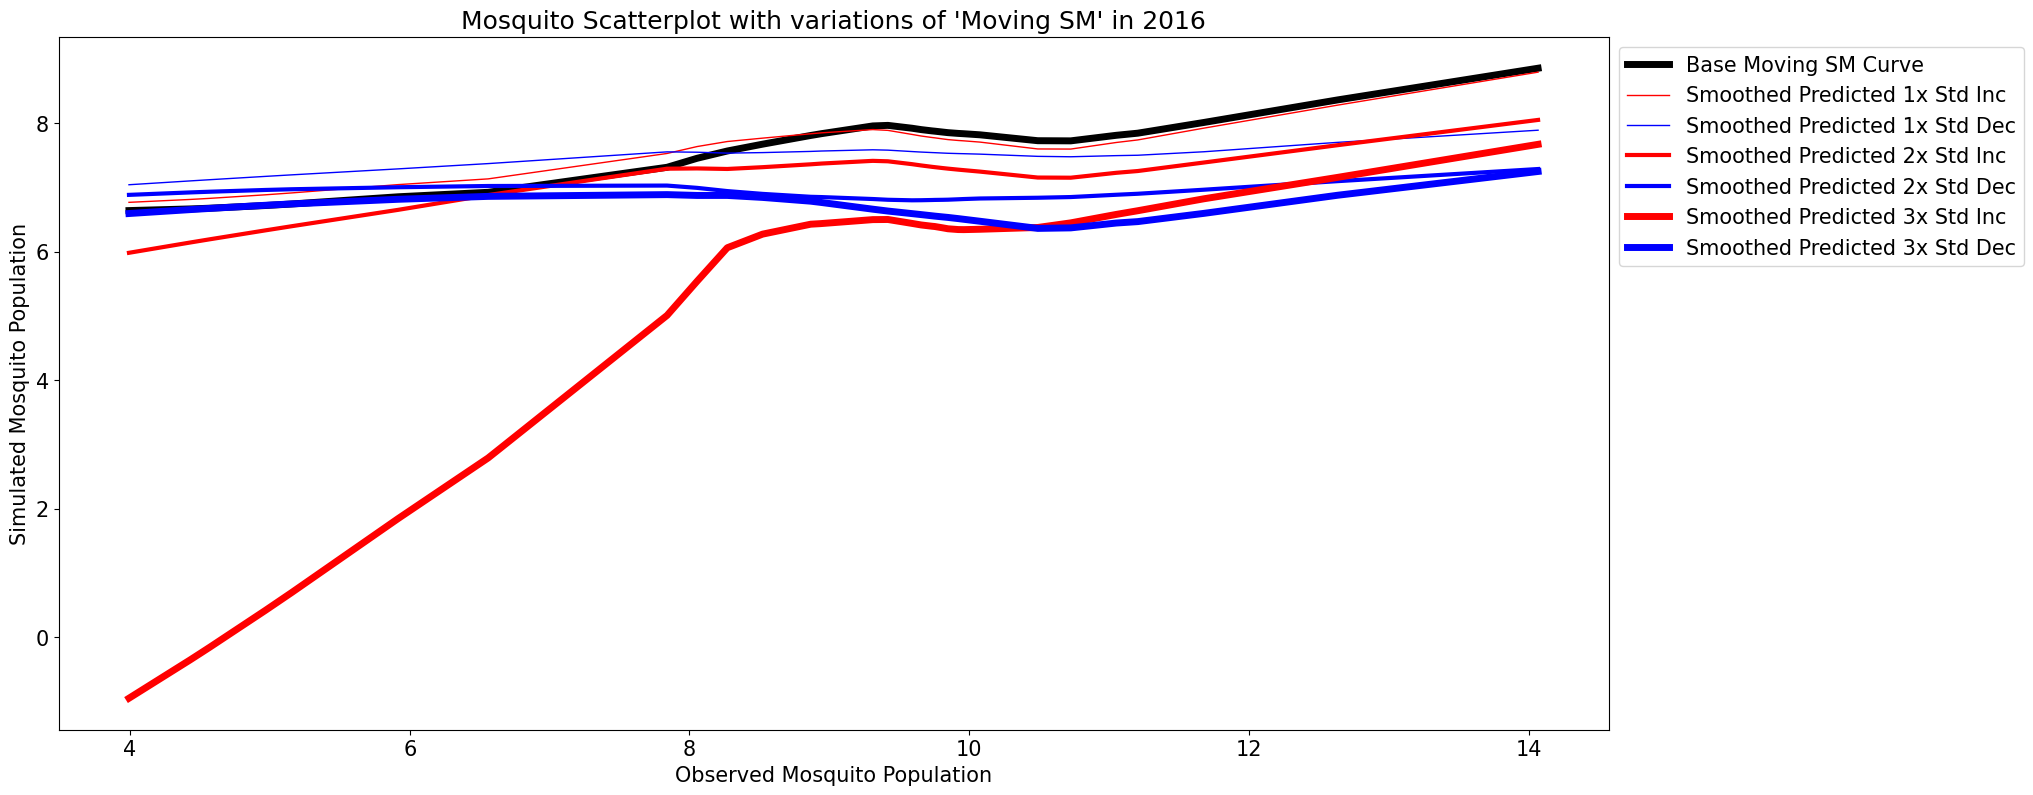

Evaluating model with variations of 'Timeskip':
7/7 [==============================] - 0s 5ms/step


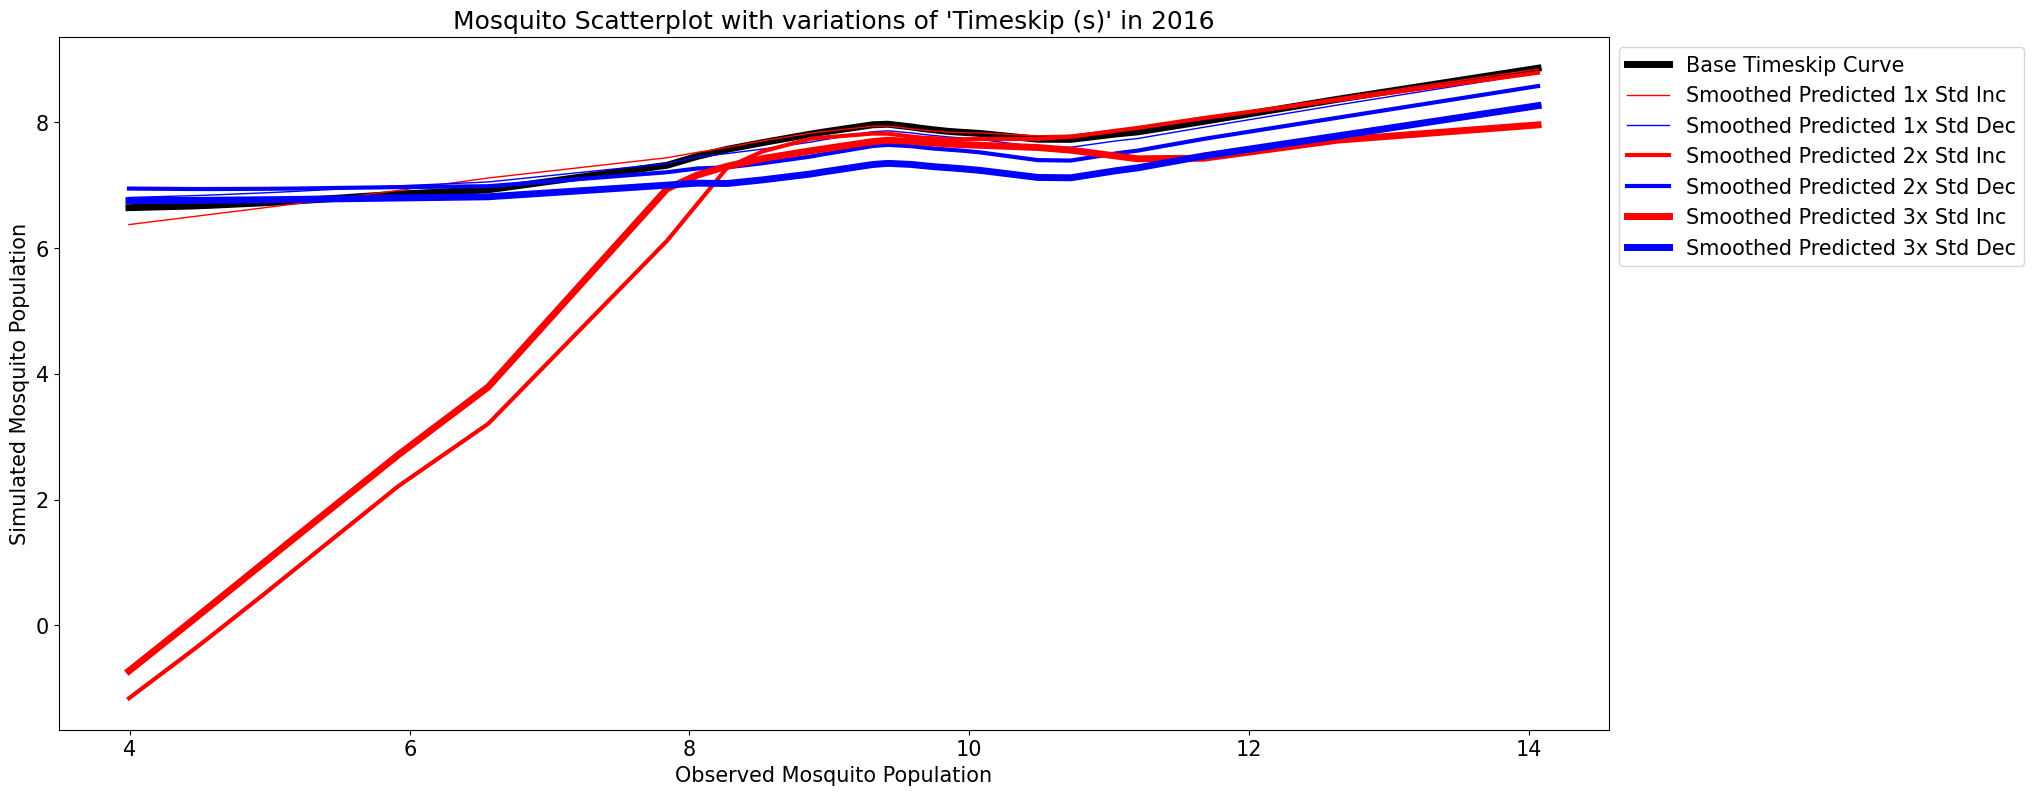

In [23]:
# Honing in a specific year for clarity of results. Plotting observed vs simulated mosquitoes to assess change more directly
SliceOfObs=ObservedDataset[ObservedDataset['Date'].dt.year==2016]
# Investigating for specific year
x_data = []
cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip','Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM','Timeskip']
units_dict = {'Moving Daylight': 's/d', 'Moving Mean Temp': '°K', 'Moving Total Precip': 'mm/d', 'Moving LAI': '', 'Moving Outflow (m^3/s)': '',
    'Moving SM': '', 'Timeskip': 's'}

# Getting values specifically for 2016
for _, row in SliceOfObs.iterrows():
    date = row['Date']
    mosquito_count = row['# of Mosquitoes Rolling']
    timeskip_value = row['Timeskip']
    start_date = date - pd.Timedelta(days=60)
    mask = (ActualObs['Date'] > start_date) & (ActualObs['Date'] <= date)
    subset_ActualObs = ActualObs[mask].copy()
    if len(subset_ActualObs) == 60:
        subset_ActualObs['Timeskip'] = timeskip_value
        subset_values = subset_ActualObs[cols].values
        x_data.append(subset_values)
        
x_data = np.array(x_data)
original_test_data = x_data.copy()
metrics = {}
results = {}
for i, feature in enumerate(cols):
    # Similar to previous box
    print(f"Evaluating model with variations of '{feature}':")
    feature_data_dec_30,feature_data_inc_30,feature_data_dec_20,feature_data_inc_20,feature_data,feature_data_inc_10,feature_data_dec_10 = get_feature_data(original_test_data, i)
    (feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10) = normalize_features(
        feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10)
    
    ypred_avg = regressor.predict(feature_data)
    ypred_avg_inc_10 = regressor.predict(feature_data_inc_10)
    ypred_avg_dec_10 = regressor.predict(feature_data_dec_10)
    ypred_avg_inc_20 = regressor.predict(feature_data_inc_20)
    ypred_avg_dec_20 = regressor.predict(feature_data_dec_20)
    ypred_avg_inc_30 = regressor.predict(feature_data_inc_30)
    ypred_avg_dec_30 = regressor.predict(feature_data_dec_30)

    # Got the obs data specifically for 2016!
    New=pd.DataFrame()
    New=ObservedDataset[ObservedDataset['Date'].dt.year==2016]
    NewMosq=New[['# of Mosquitoes Rolling','Date']].reset_index(drop=True)

    # Observational data is set as the actual mosquito rolling data
    TestNo0 = pd.DataFrame()
    TestNo0['Actual Mosquito Data'] = New['# of Mosquitoes Rolling'] 
    TestNo0['Mosquito Predictions Average'] = ypred_avg.flatten()
    TestNo0['Mosquito Predictions .1 Inc'] = ypred_avg_inc_10.flatten()
    TestNo0['Mosquito Predictions .1 Dec'] = ypred_avg_dec_10.flatten()
    TestNo0['Mosquito Predictions .2 Inc'] = ypred_avg_inc_20.flatten()
    TestNo0['Mosquito Predictions .2 Dec'] = ypred_avg_dec_20.flatten()
    TestNo0['Mosquito Predictions .3 Inc'] = ypred_avg_inc_30.flatten()
    TestNo0['Mosquito Predictions .3 Dec'] = ypred_avg_dec_30.flatten()
    TestNo0['Observational Data'] = New['# of Mosquitoes Rolling'] 
    TestNo0 = TestNo0[TestNo0['Actual Mosquito Data'] != 0]
    
    results[feature] = {"Modeled Avg Density": TestNo0['Mosquito Predictions Average'].mean(),
        "Modeled .1 Inc Density": TestNo0['Mosquito Predictions .1 Inc'].mean(), "Modeled .1 Dec Density": TestNo0['Mosquito Predictions .1 Dec'].mean(),
        "Modeled .2 Inc Density": TestNo0['Mosquito Predictions .2 Inc'].mean(), "Modeled .2 Dec Density": TestNo0['Mosquito Predictions .2 Dec'].mean(),
        "Modeled .3 Inc Density": TestNo0['Mosquito Predictions .3 Inc'].mean(), "Modeled .3 Dec Density": TestNo0['Mosquito Predictions .3 Dec'].mean(),
        "Observed Density": TestNo0['Actual Mosquito Data'].mean()}

    # Modeling - Seeing actual vs simulated mosquito populations
    plt.close('all')
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions Average'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label=f'Base {feature} Curve', color='black', linewidth=5)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 1x Std Inc', color='red', linewidth=1)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 1x Std Dec', color='blue', linewidth=1)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 2x Std Inc', color='red', linewidth=3)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 2x Std Dec', color='blue', linewidth=3)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 3x Std Inc', color='red', linewidth=5)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 3x Std Dec', color='blue', linewidth=5)

    unit_str = f" ({units_dict[feature]})" if units_dict[feature] != '' else ''
    plt.title(f"Mosquito Scatterplot with variations of '{feature}{unit_str}' in 2016")

    plt.ylabel('Simulated Mosquito Population')
    plt.xlabel('Observed Mosquito Population')
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.show()

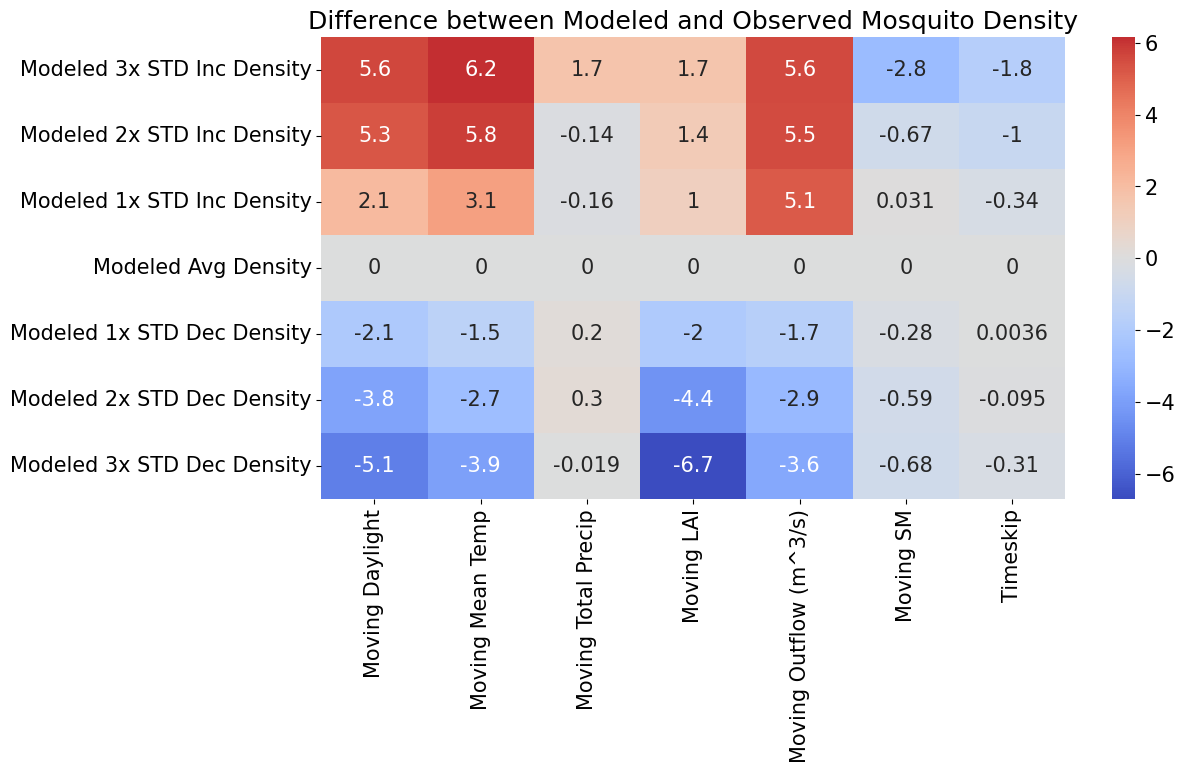

In [24]:
# Creating a comprehensive heatmap for average variable differences between average and changed feature mosquito simulation
df_differences = pd.DataFrame(index=cols)
intervals = [0.3, 0.2, 0.1] 
for feature in cols:
    diff_key = "Modeled Avg Density"
    df_differences.loc[feature, diff_key] = results[feature][diff_key] - results[feature]["Modeled Avg Density"] #The difference for avg
    # Diff for the inc/dec
    for interval in intervals:
        inc_key = f"Modeled .{int(interval*10)} Inc Density"
        dec_key = f"Modeled .{int(interval*10)} Dec Density"
        df_differences.loc[feature, inc_key] = results[feature][inc_key] - results[feature]["Modeled Avg Density"]
        df_differences.loc[feature, dec_key] = results[feature][dec_key] - results[feature]["Modeled Avg Density"]

# Getting it in a more reasonable order
df_differences_transposed = df_differences.T
custom_order = ["Modeled .3 Inc Density", "Modeled .2 Inc Density", "Modeled .1 Inc Density", "Modeled Avg Density",
                "Modeled .1 Dec Density", "Modeled .2 Dec Density", "Modeled .3 Dec Density"]
label_mapping = {
    "Modeled .3 Inc Density": "Modeled 3x STD Inc Density", "Modeled .2 Inc Density": "Modeled 2x STD Inc Density",
    "Modeled .1 Inc Density": "Modeled 1x STD Inc Density", "Modeled Avg Density": "Modeled Avg Density",
    "Modeled .1 Dec Density": "Modeled 1x STD Dec Density", "Modeled .2 Dec Density": "Modeled 2x STD Dec Density",
    "Modeled .3 Dec Density": "Modeled 3x STD Dec Density"}

# Transposed for a better figure - have those labels on the Y
df_differences_ordered = df_differences_transposed.loc[custom_order]
df_differences_ordered = df_differences_ordered.rename(index=label_mapping)
plt.figure(figsize=(12, 6))
sns.heatmap(df_differences_ordered, annot=True, cmap="coolwarm", center=0)
plt.title("Difference between Modeled and Observed Mosquito Density")
plt.show()

Evaluating model with variations of 'Moving Daylight':
5/5 [==============================] - 0s 8ms/step


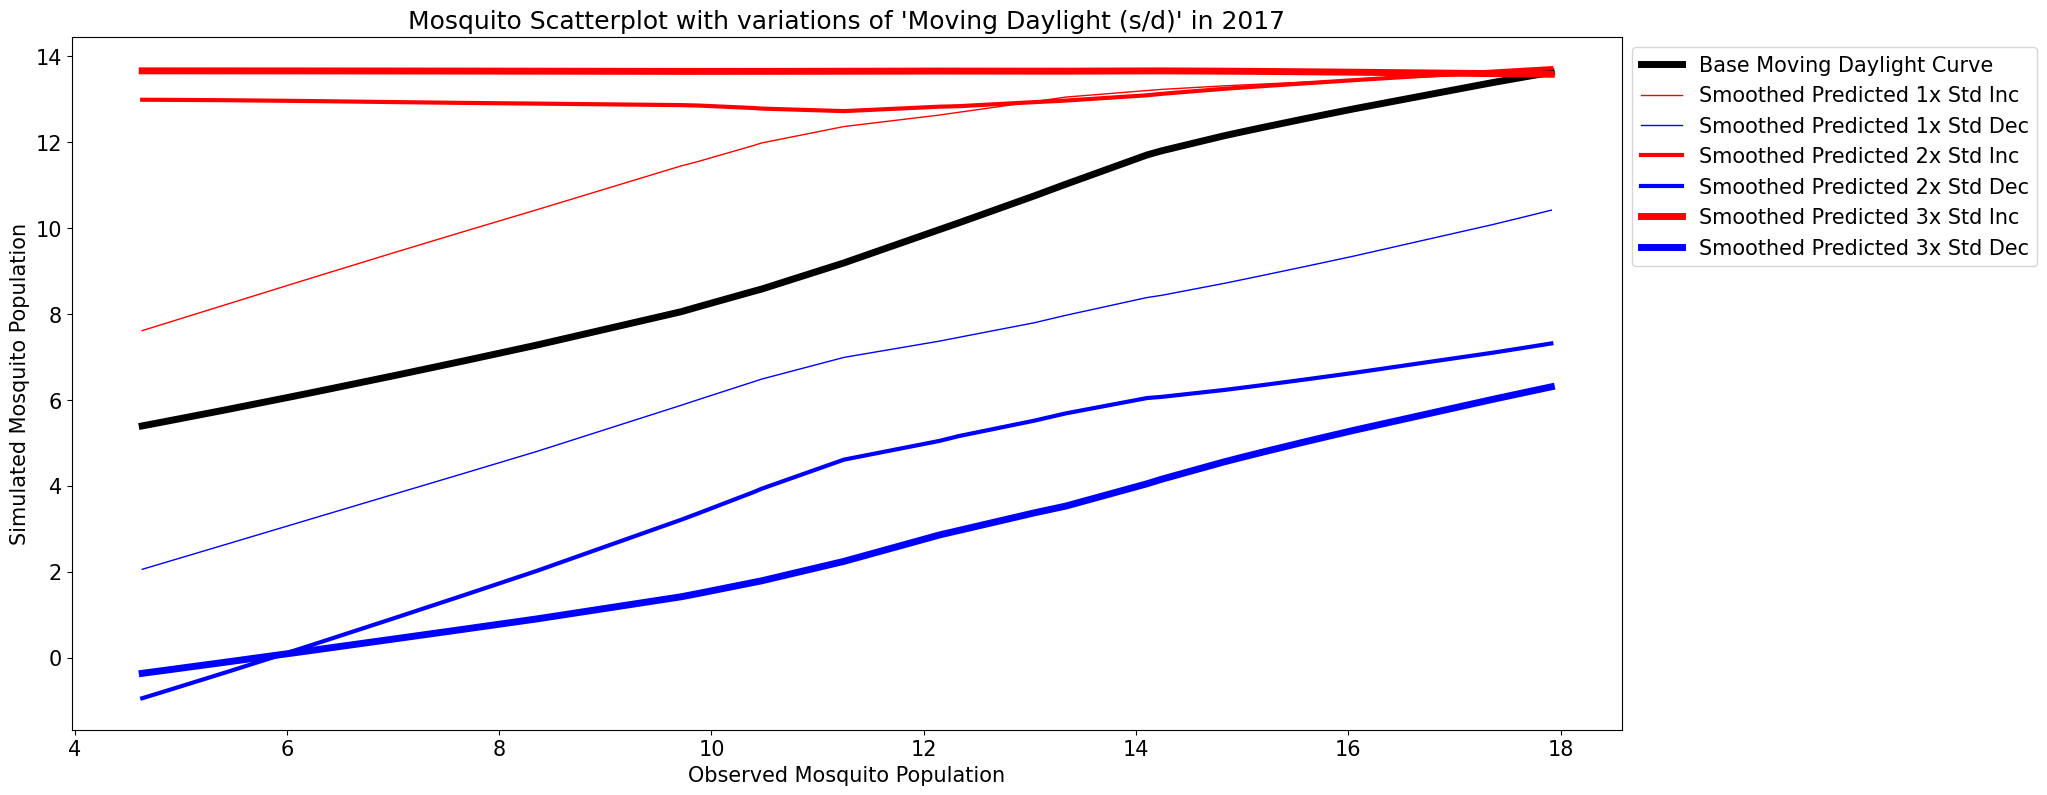

Evaluating model with variations of 'Moving Mean Temp':
5/5 [==============================] - 0s 10ms/step


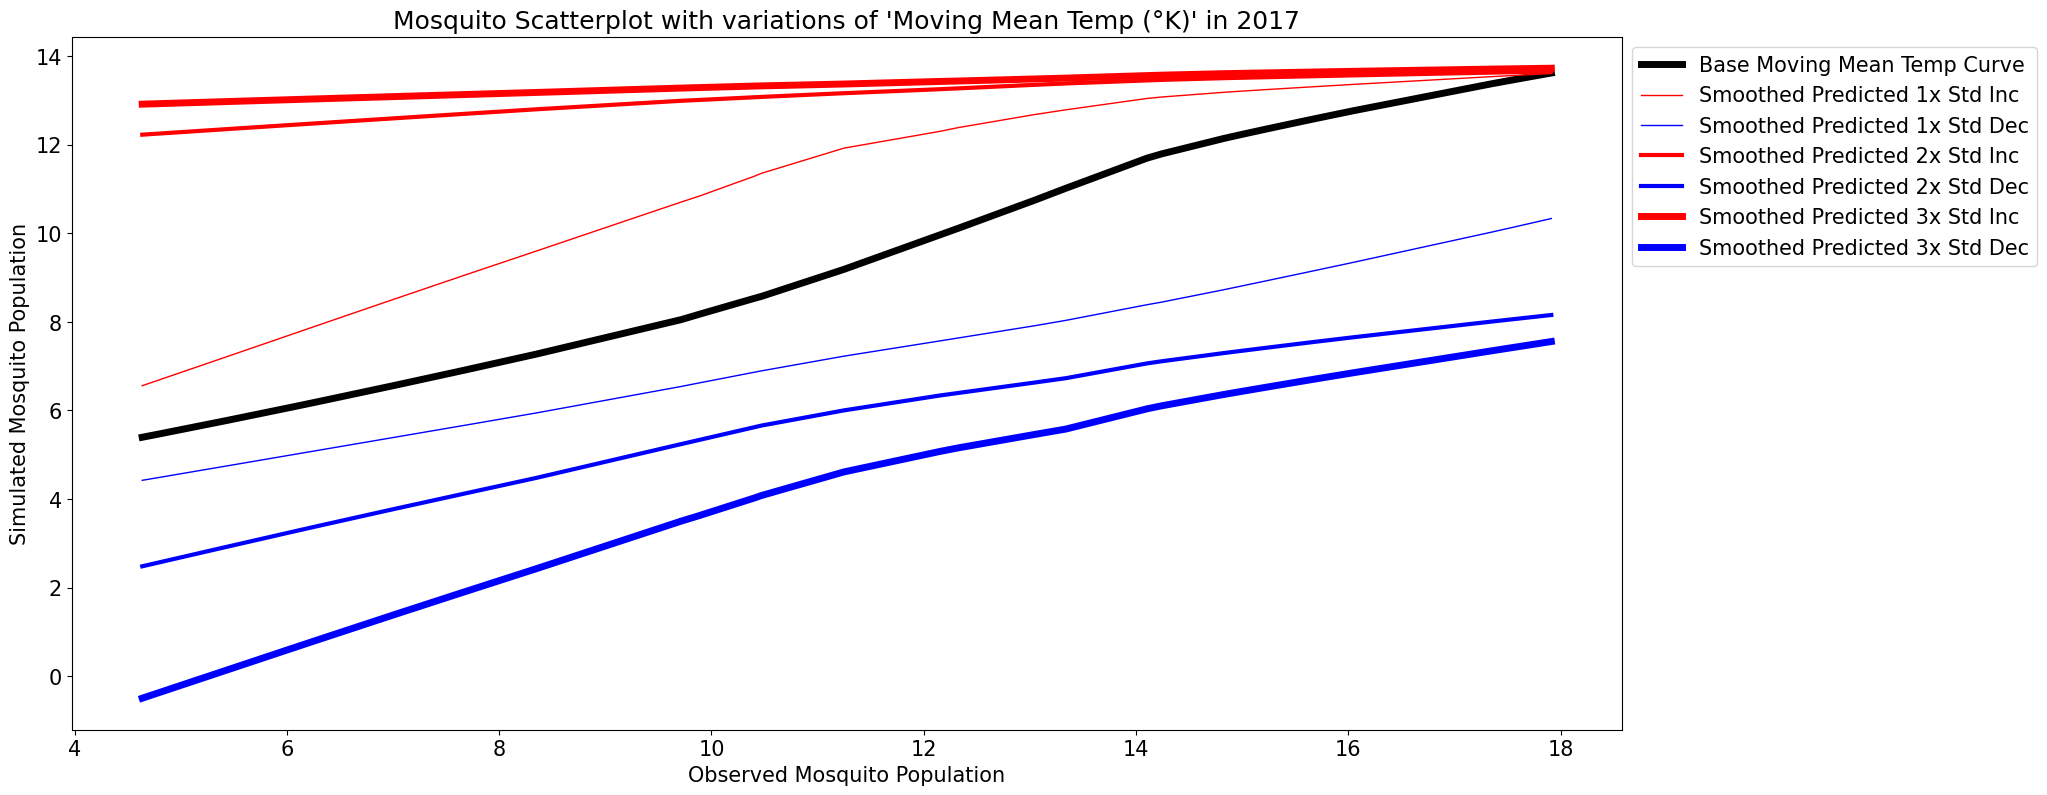

Evaluating model with variations of 'Moving Total Precip':
5/5 [==============================] - 0s 10ms/step


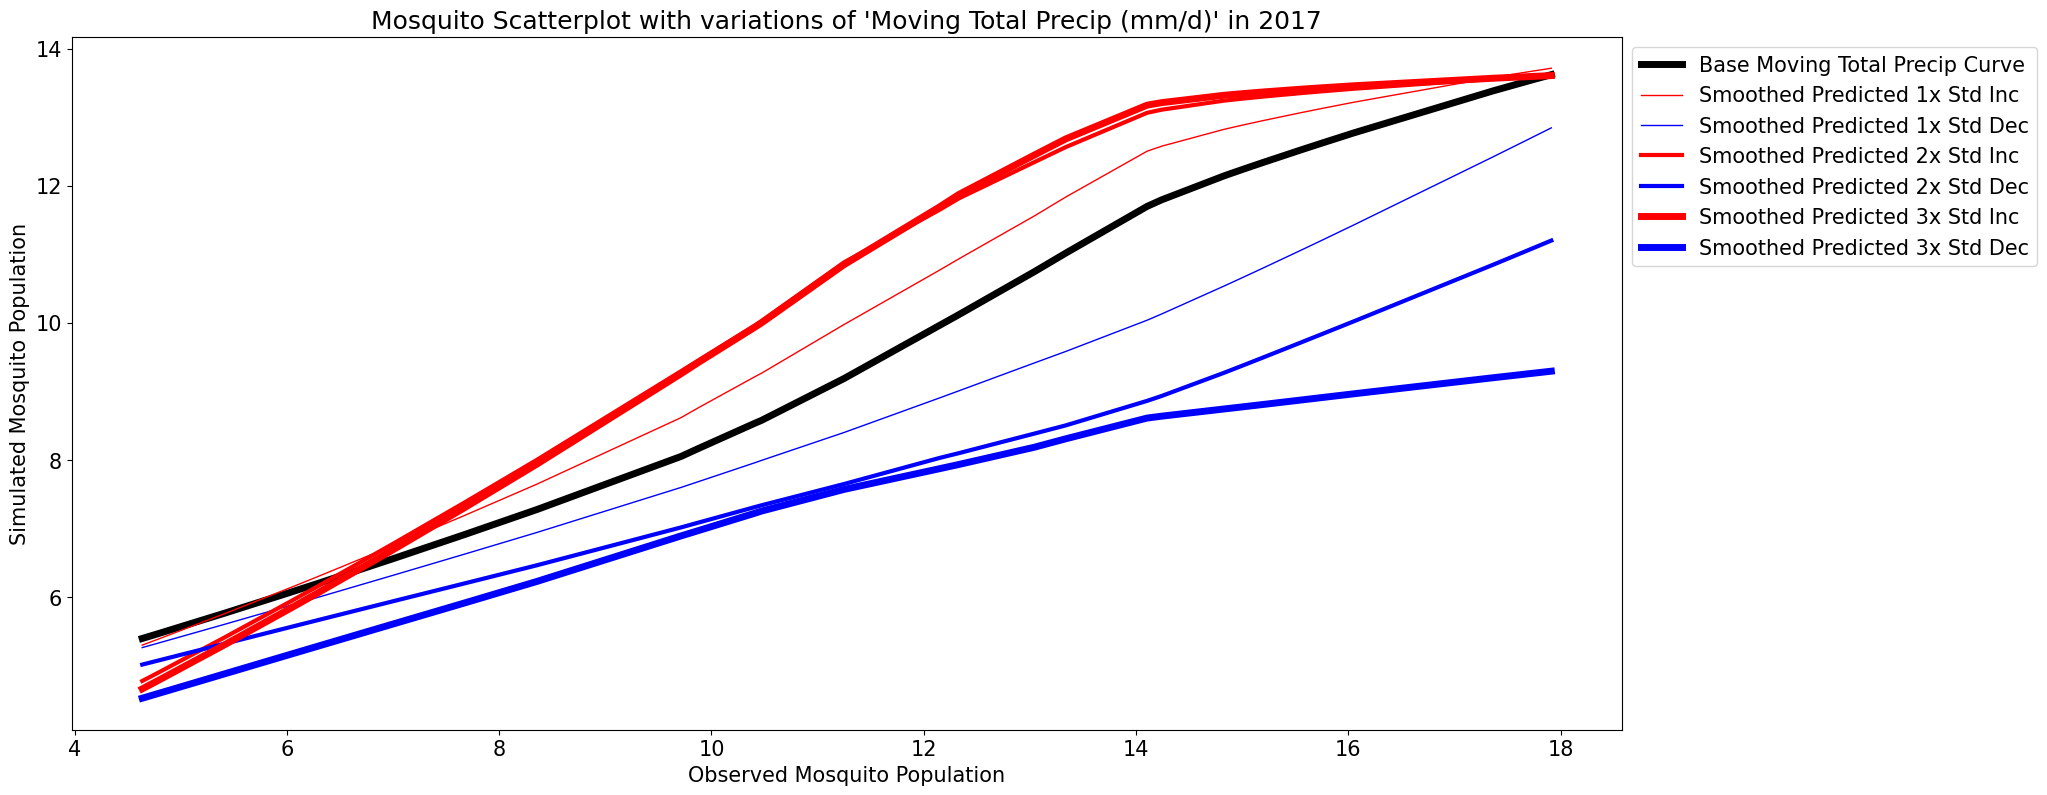

Evaluating model with variations of 'Moving LAI':
5/5 [==============================] - 0s 9ms/step


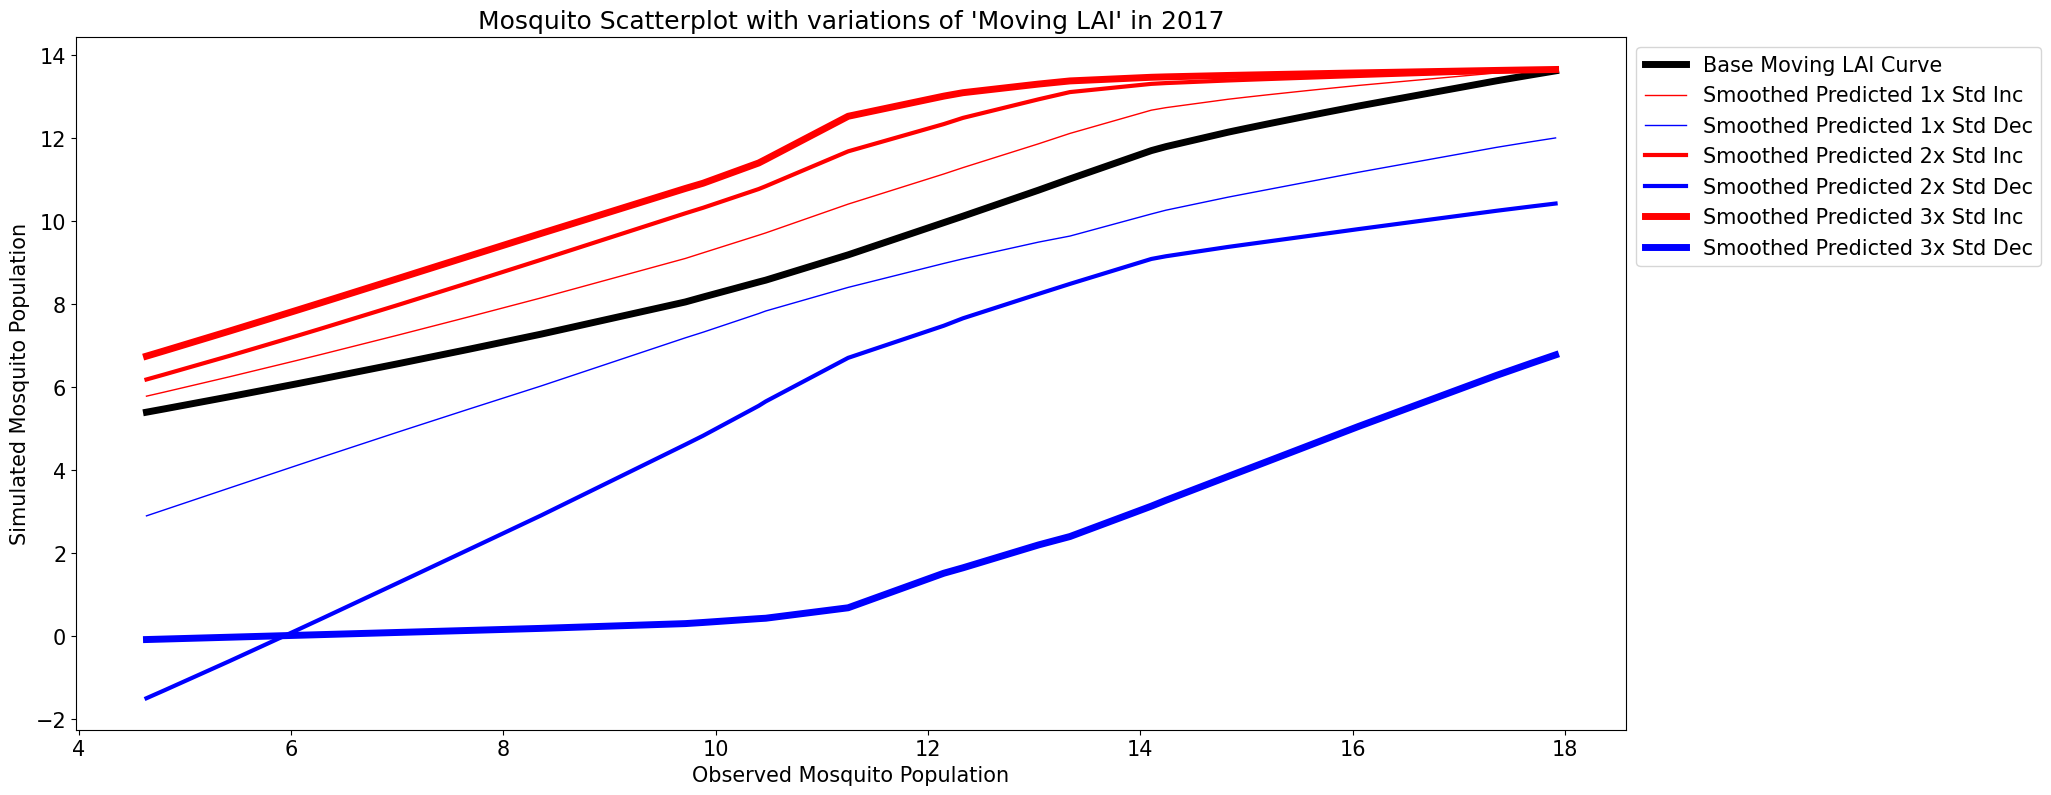

Evaluating model with variations of 'Moving Outflow (m^3/s)':
5/5 [==============================] - 0s 8ms/step


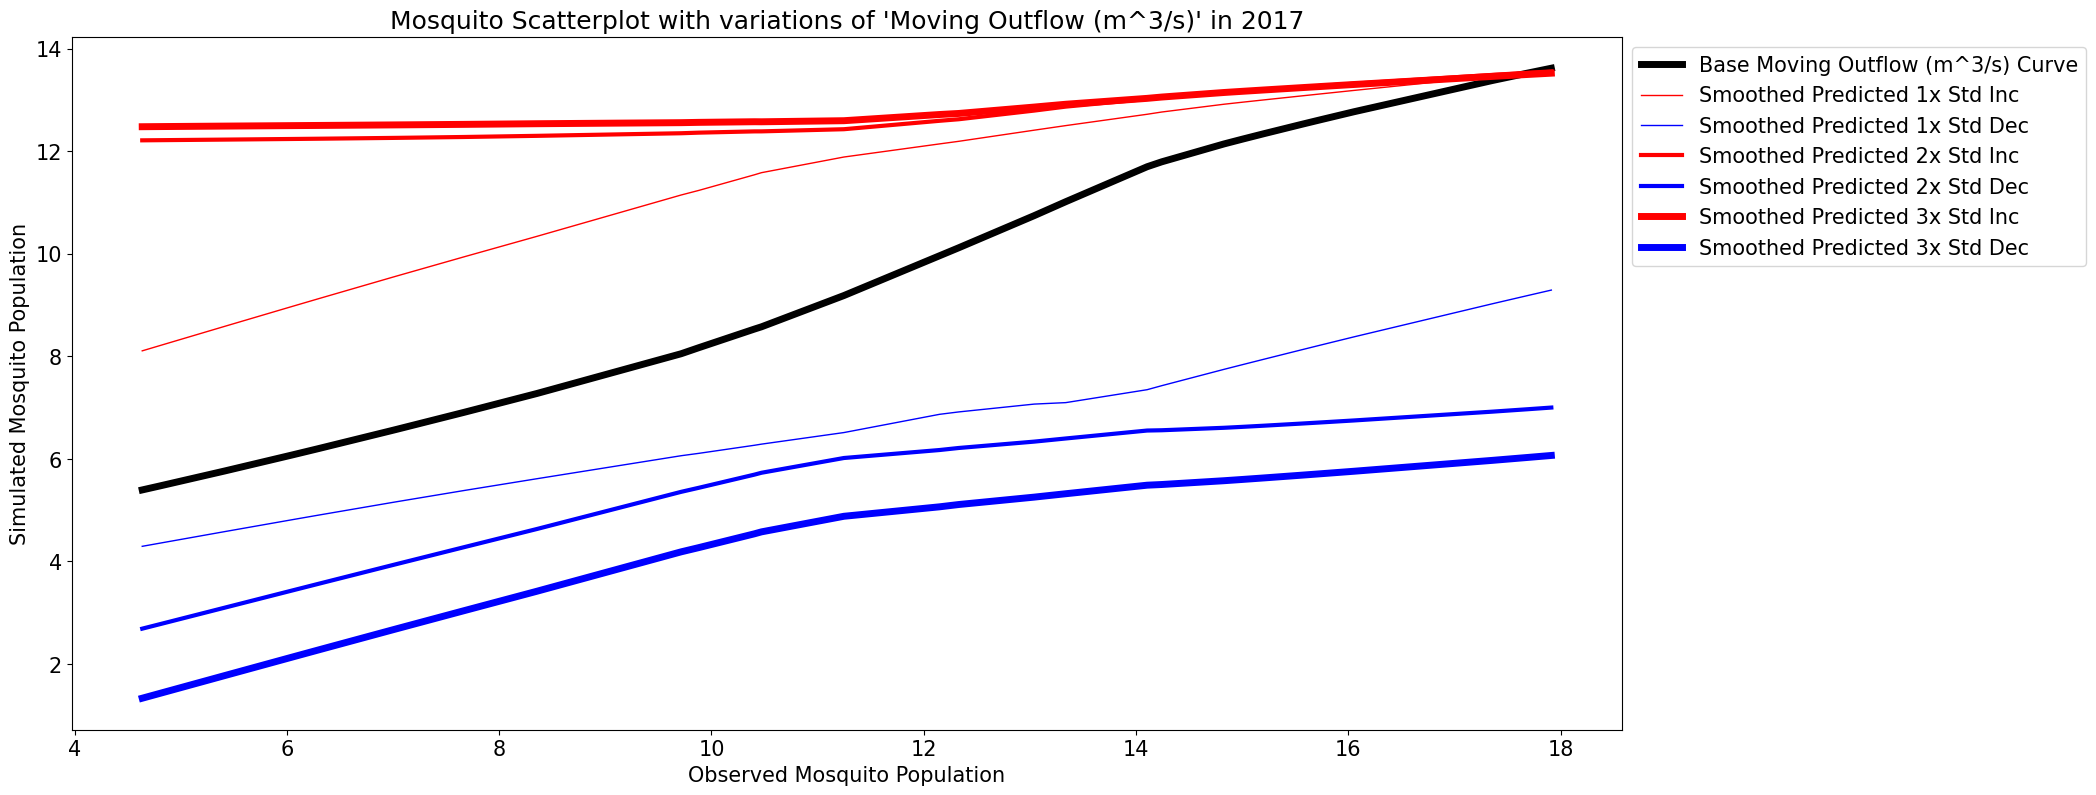

Evaluating model with variations of 'Moving SM':
5/5 [==============================] - 0s 7ms/step


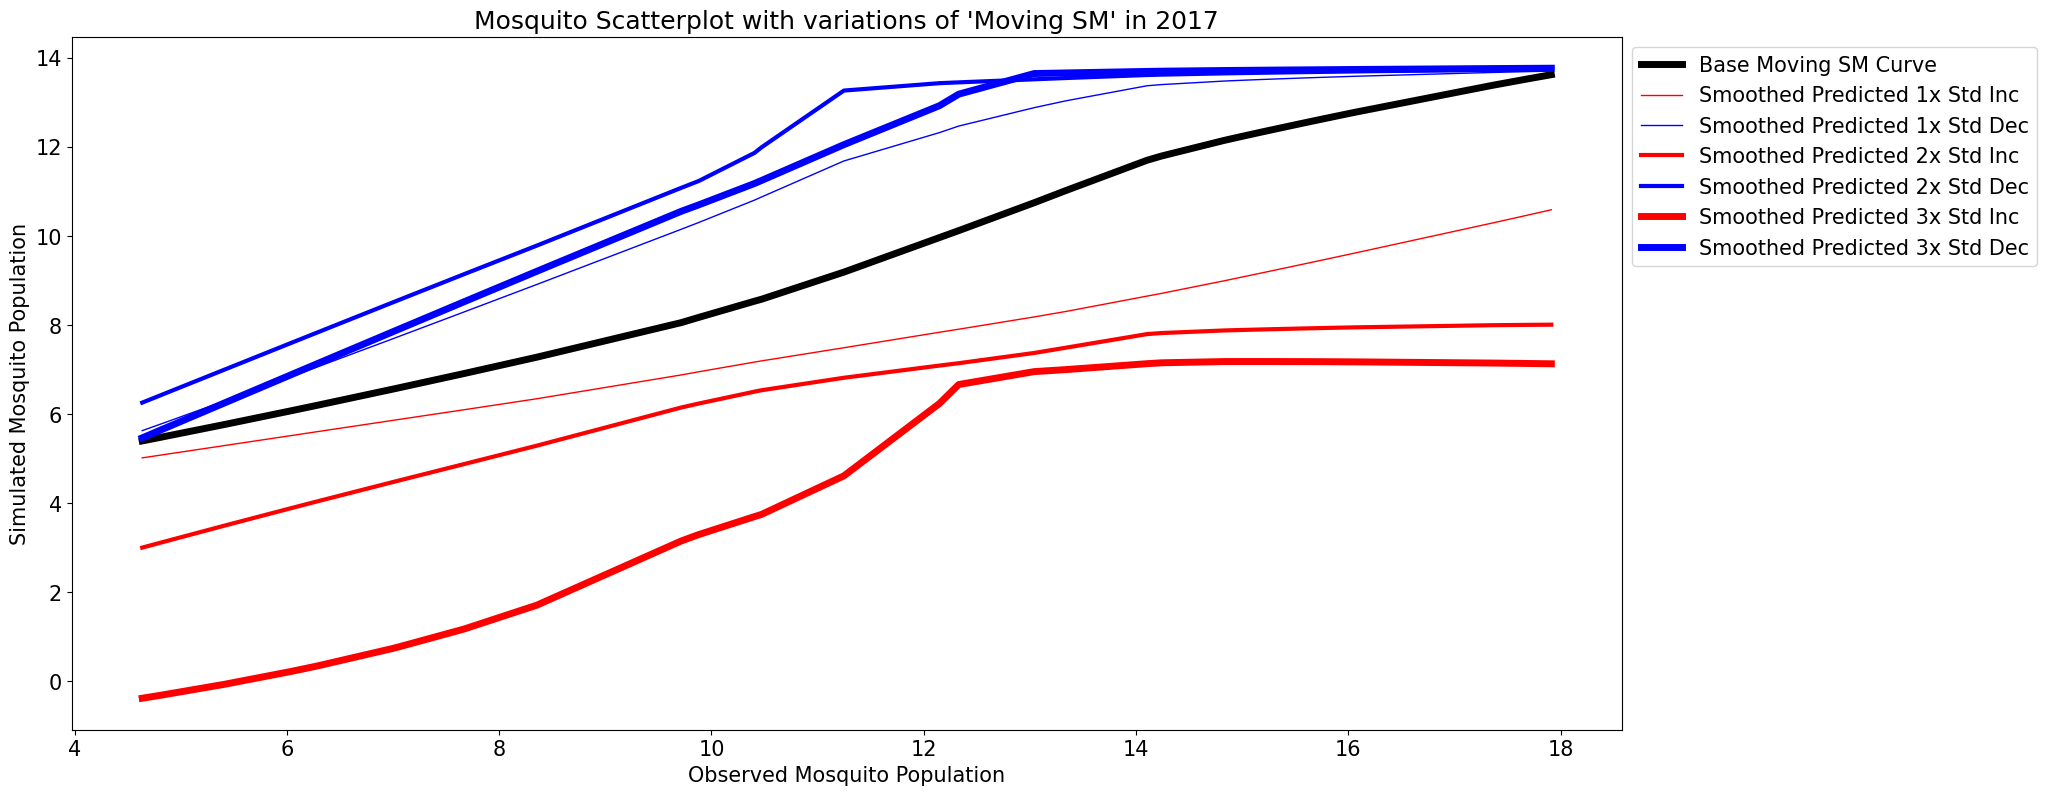

Evaluating model with variations of 'Timeskip':
5/5 [==============================] - 0s 11ms/step


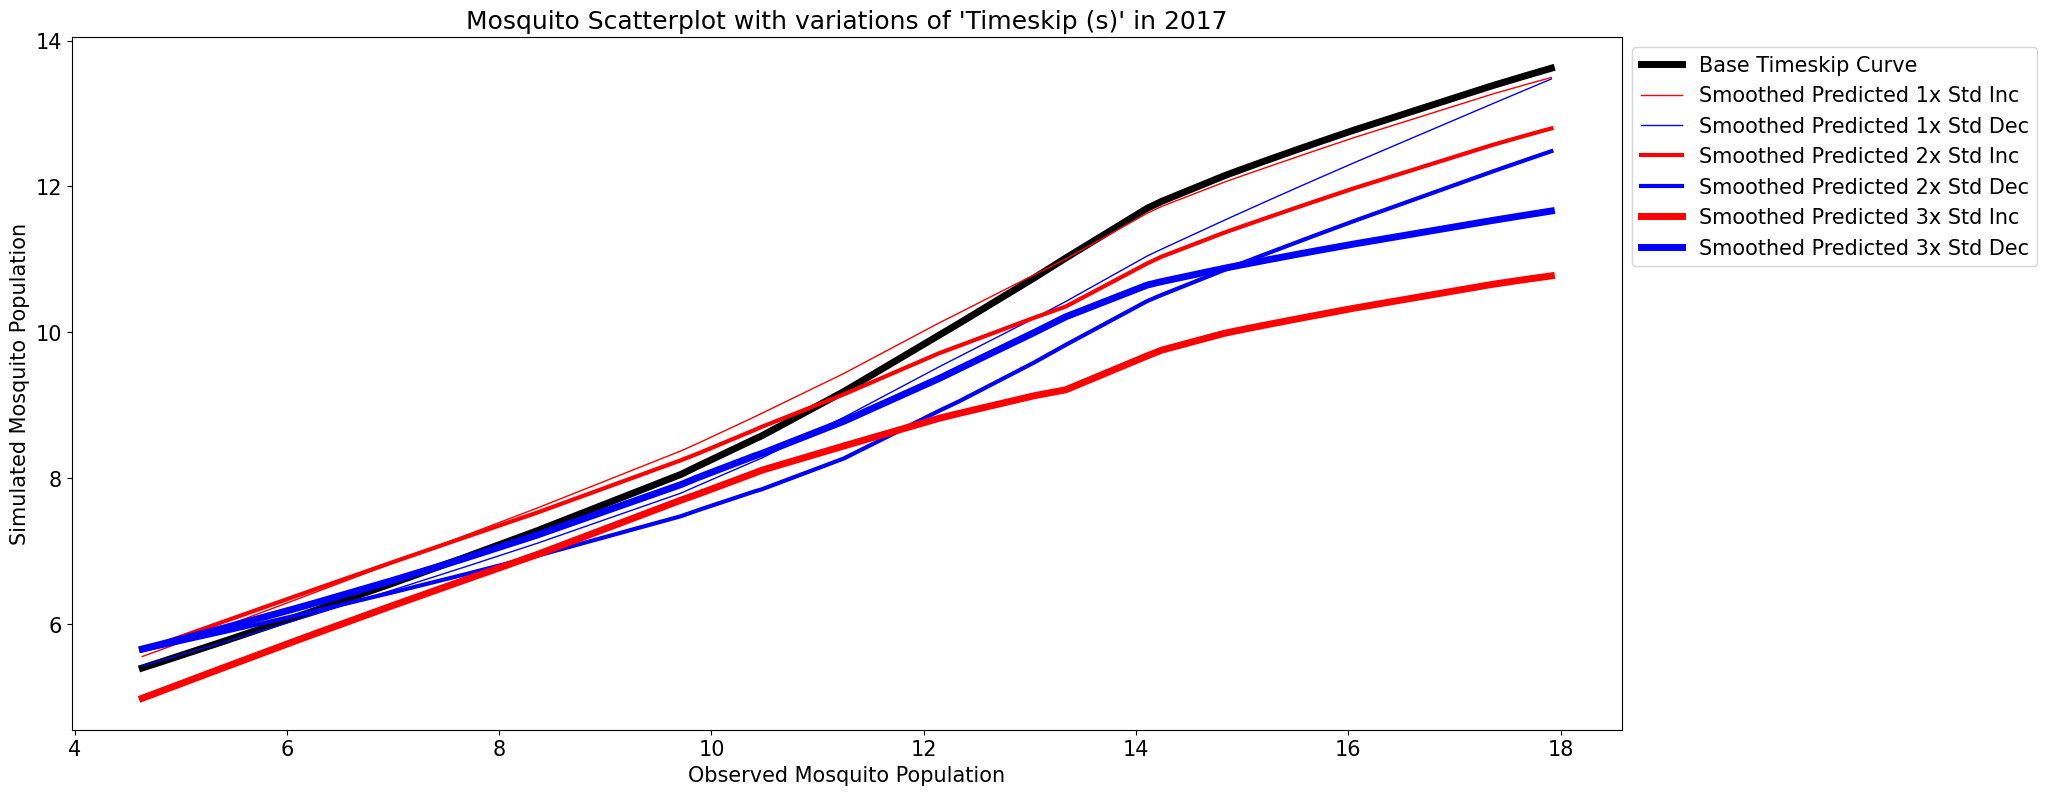

In [25]:
# Honing in a specific year for clarity of results. Plotting observed vs simulated mosquitoes to assess change more directly
SliceOfObs=ObservedDataset[ObservedDataset['Date'].dt.year==2017]
# Investigating for specific year
x_data = []
cols = ['Moving Daylight', 'Moving Mean Temp', 'Moving Total Precip','Moving LAI', 'Moving Outflow (m^3/s)', 'Moving SM','Timeskip']
units_dict = {'Moving Daylight': 's/d', 'Moving Mean Temp': '°K', 'Moving Total Precip': 'mm/d', 'Moving LAI': '', 'Moving Outflow (m^3/s)': '',
    'Moving SM': '', 'Timeskip': 's'}

# Getting values specifically for 2017
for _, row in SliceOfObs.iterrows():
    date = row['Date']
    mosquito_count = row['# of Mosquitoes Rolling']
    timeskip_value = row['Timeskip']
    start_date = date - pd.Timedelta(days=60)
    mask = (ActualObs['Date'] > start_date) & (ActualObs['Date'] <= date)
    subset_ActualObs = ActualObs[mask].copy()
    if len(subset_ActualObs) == 60:
        subset_ActualObs['Timeskip'] = timeskip_value
        subset_values = subset_ActualObs[cols].values
        x_data.append(subset_values)
        
x_data = np.array(x_data)
original_test_data = x_data.copy()
metrics = {}
results = {}
for i, feature in enumerate(cols):
    # Similar to previous box
    print(f"Evaluating model with variations of '{feature}':")
    feature_data_dec_30,feature_data_inc_30,feature_data_dec_20,feature_data_inc_20,feature_data,feature_data_inc_10,feature_data_dec_10 = get_feature_data(original_test_data, i)
    (feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10) = normalize_features(
        feature_data_dec_30, feature_data_inc_30, feature_data_dec_20, feature_data_inc_20, feature_data, feature_data_inc_10, feature_data_dec_10)
    
    ypred_avg = regressor.predict(feature_data)
    ypred_avg_inc_10 = regressor.predict(feature_data_inc_10)
    ypred_avg_dec_10 = regressor.predict(feature_data_dec_10)
    ypred_avg_inc_20 = regressor.predict(feature_data_inc_20)
    ypred_avg_dec_20 = regressor.predict(feature_data_dec_20)
    ypred_avg_inc_30 = regressor.predict(feature_data_inc_30)
    ypred_avg_dec_30 = regressor.predict(feature_data_dec_30)

    # Got the obs data specifically for 2017!
    New=pd.DataFrame()
    New=ObservedDataset[ObservedDataset['Date'].dt.year==2017]
    NewMosq=New[['# of Mosquitoes Rolling','Date']].reset_index(drop=True)

    # Observational data is set as the actual mosquito rolling data
    TestNo0 = pd.DataFrame()
    TestNo0['Actual Mosquito Data'] = New['# of Mosquitoes Rolling'] 
    TestNo0['Mosquito Predictions Average'] = ypred_avg.flatten()
    TestNo0['Mosquito Predictions .1 Inc'] = ypred_avg_inc_10.flatten()
    TestNo0['Mosquito Predictions .1 Dec'] = ypred_avg_dec_10.flatten()
    TestNo0['Mosquito Predictions .2 Inc'] = ypred_avg_inc_20.flatten()
    TestNo0['Mosquito Predictions .2 Dec'] = ypred_avg_dec_20.flatten()
    TestNo0['Mosquito Predictions .3 Inc'] = ypred_avg_inc_30.flatten()
    TestNo0['Mosquito Predictions .3 Dec'] = ypred_avg_dec_30.flatten()
    TestNo0['Observational Data'] = New['# of Mosquitoes Rolling'] 
    TestNo0 = TestNo0[TestNo0['Actual Mosquito Data'] != 0]
    
    results[feature] = {"Modeled Avg Density": TestNo0['Mosquito Predictions Average'].mean(),
        "Modeled .1 Inc Density": TestNo0['Mosquito Predictions .1 Inc'].mean(), "Modeled .1 Dec Density": TestNo0['Mosquito Predictions .1 Dec'].mean(),
        "Modeled .2 Inc Density": TestNo0['Mosquito Predictions .2 Inc'].mean(), "Modeled .2 Dec Density": TestNo0['Mosquito Predictions .2 Dec'].mean(),
        "Modeled .3 Inc Density": TestNo0['Mosquito Predictions .3 Inc'].mean(), "Modeled .3 Dec Density": TestNo0['Mosquito Predictions .3 Dec'].mean(),
        "Observed Density": TestNo0['Actual Mosquito Data'].mean()}

    # Modeling - Seeing actual vs simulated mosquito populations
    plt.close('all')
    smoothed_predicted = lowess(TestNo0['Mosquito Predictions Average'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label=f'Base {feature} Curve', color='black', linewidth=5)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 1x Std Inc', color='red', linewidth=1)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .1 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 1x Std Dec', color='blue', linewidth=1)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 2x Std Inc', color='red', linewidth=3)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .2 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 2x Std Dec', color='blue', linewidth=3)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Inc'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 3x Std Inc', color='red', linewidth=5)

    smoothed_predicted = lowess(TestNo0['Mosquito Predictions .3 Dec'], TestNo0['Observational Data'])
    plt.plot(smoothed_predicted[:, 0], smoothed_predicted[:, 1], label='Smoothed Predicted 3x Std Dec', color='blue', linewidth=5)

    unit_str = f" ({units_dict[feature]})" if units_dict[feature] != '' else ''
    plt.title(f"Mosquito Scatterplot with variations of '{feature}{unit_str}' in 2017")

    plt.ylabel('Simulated Mosquito Population')
    plt.xlabel('Observed Mosquito Population')
    plt.legend(loc='upper left',bbox_to_anchor=(1,1))
    plt.show()

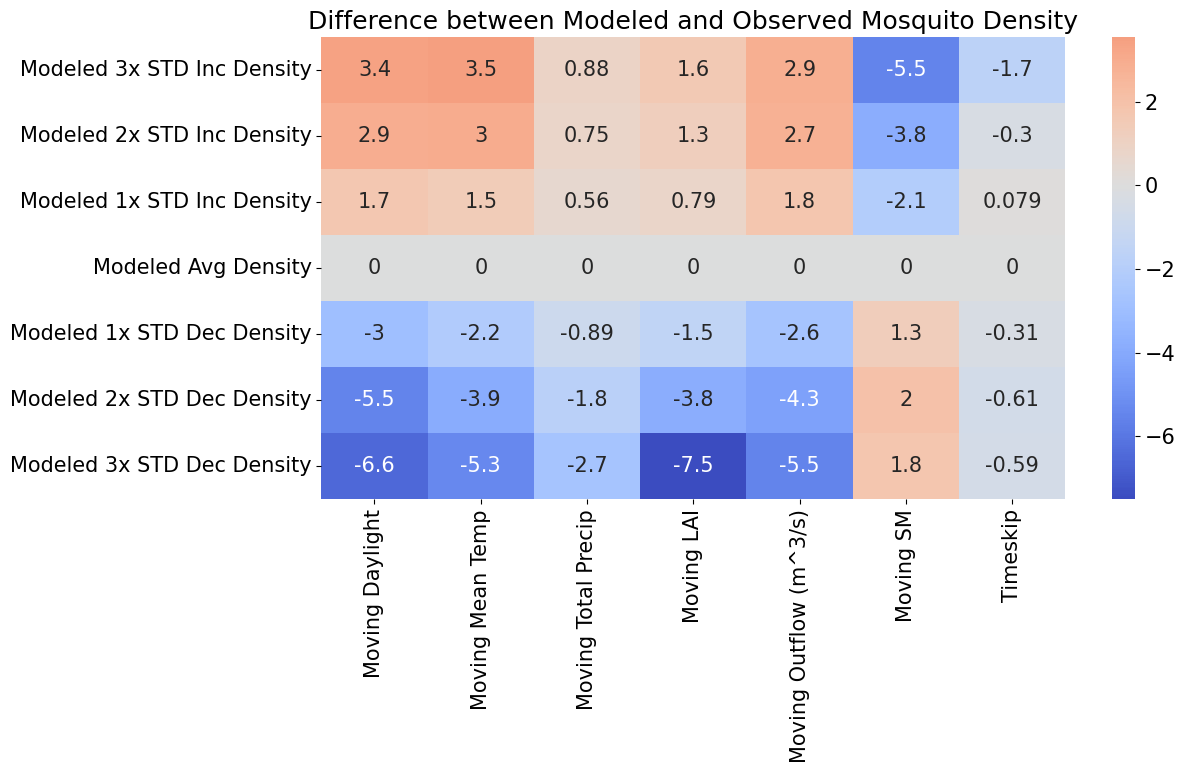

In [26]:
# Creating a comprehensive heatmap for average variable differences between average and changed feature mosquito simulation
df_differences = pd.DataFrame(index=cols)
intervals = [0.3, 0.2, 0.1] 
for feature in cols:
    diff_key = "Modeled Avg Density"
    df_differences.loc[feature, diff_key] = results[feature][diff_key] - results[feature]["Modeled Avg Density"] #The difference for avg
    # Diff for the inc/dec
    for interval in intervals:
        inc_key = f"Modeled .{int(interval*10)} Inc Density"
        dec_key = f"Modeled .{int(interval*10)} Dec Density"
        df_differences.loc[feature, inc_key] = results[feature][inc_key] - results[feature]["Modeled Avg Density"]
        df_differences.loc[feature, dec_key] = results[feature][dec_key] - results[feature]["Modeled Avg Density"]

# Getting it in a more reasonable order
df_differences_transposed = df_differences.T
custom_order = ["Modeled .3 Inc Density", "Modeled .2 Inc Density", "Modeled .1 Inc Density", "Modeled Avg Density",
                "Modeled .1 Dec Density", "Modeled .2 Dec Density", "Modeled .3 Dec Density"]
label_mapping = {
    "Modeled .3 Inc Density": "Modeled 3x STD Inc Density", "Modeled .2 Inc Density": "Modeled 2x STD Inc Density",
    "Modeled .1 Inc Density": "Modeled 1x STD Inc Density", "Modeled Avg Density": "Modeled Avg Density",
    "Modeled .1 Dec Density": "Modeled 1x STD Dec Density", "Modeled .2 Dec Density": "Modeled 2x STD Dec Density",
    "Modeled .3 Dec Density": "Modeled 3x STD Dec Density"}

# Transposed for a better figure - have those labels on the Y
df_differences_ordered = df_differences_transposed.loc[custom_order]
df_differences_ordered = df_differences_ordered.rename(index=label_mapping)
plt.figure(figsize=(12, 6))
sns.heatmap(df_differences_ordered, annot=True, cmap="coolwarm", center=0)
plt.title("Difference between Modeled and Observed Mosquito Density")
plt.show()